あまりに尤度比が出ないしパラメタの値も変なので観測モデルの出力がおかしいのではないかという疑問

In [38]:
##### 同時推定コード #####
import pandas as pd 
import os
import datetime
import numpy as np
from datetime import timedelta 
import csv
import time
import math
from scipy.stats import norm
from scipy.optimize import minimize

start_time = time.time()
print('start!')

####### reading data #######
# 実態リンクのうち片方向のリンクのみ入れたもの．観測モデルに使う．観測モデルでは仮想リンクや吸収リンクは関係ない上，グラフの向きも判定できないので．各リンクidに+1したものが逆方向リンクに対応
df_link_odds = pd.read_csv("/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link/shibuya_link_pre_odds.csv")
l = len(df_link_odds)

# ここには仮想リンクと吸収リンクを入れている
df_link_integrated = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link/shibuya_link_pre_integrated.csv')
L = len(df_link_integrated)

# 17:00-17:15からさらに絞ったデータを使用
search_folder = "/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20221218_17/quater_address750"
file_list = list(os.listdir(search_folder))

# ここは常に変わらない
df_node = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_node.csv')
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')

###### 各linkのoとdの座標を入れておく配列 ######
oddslink_loc_array = [] # 空リストを用意
for i in range(len(df_link_odds)):
    linkid = df_link_odds.loc[i, 'linkid']
    O = df_link_odds.loc[i, 'O']
    D = df_link_odds.loc[i, 'D']

    x_o = df_node[df_node['nodeid'] == O]['x'].iloc[0]
    y_o = df_node[df_node['nodeid'] == O]['y'].iloc[0]
    z_o = df_node[df_node['nodeid'] == O]['floor'].iloc[0] * 1000
    o_loc = np.array([x_o, y_o, z_o])

    x_d = df_node[df_node['nodeid'] == D]['x'].iloc[0]
    y_d = df_node[df_node['nodeid'] == D]['y'].iloc[0]
    z_d = df_node[df_node['nodeid'] == D]['floor'].iloc[0] * 1000 # これでseriesではなく値として抽出できるはず
    d_loc = np.array([x_d, y_d, z_d])

    loc_tuple = (o_loc, d_loc)

    oddslink_loc_array.append(loc_tuple) # oddslink_loc_array[linkid//2][0]がlinkidのonode, [1]がdnode，[2]が中点，，，，

###### ビーコンとリンク線分の最短距離返す関数 ######
def shortest_distance_to_segment(p1, p2, x):
    p1 = np.array(p1)
    p2 = np.array(p2)
    x = np.array(x)
    
    segment = p2 - p1
    v1 = x - p1
    v2 = x - p2
    
    # 垂直ベクトルを計算
    v = v1 - np.dot(v1, segment) / np.dot(segment, segment) * segment
    
    # 垂直ベクトルのノルム（距離）を求める
    distance = np.linalg.norm(v)
    
    # 線分の範囲内であるかチェック
    dot_product = np.dot(v1, segment)
    if dot_product < 0:
        return np.linalg.norm(x - p1)
    elif dot_product > np.dot(segment, segment):
        return np.linalg.norm(x - p2)
    else:
        return distance

###### d_arrayの用意 ######
d_array = np.zeros((len(df_link_odds), len(df_ble))) # 各リンク(奇数側)とbleビーコンとの距離配列

for i in range(len(df_link_odds)):
    p_o = oddslink_loc_array[i][0] # o座標 # i=1の時
    p_d = oddslink_loc_array[i][1] # d座標

    for j in range(len(df_ble)):
        x_ap = df_ble.loc[j, 'x']
        y_ap = df_ble.loc[j, 'y']
        z_ap = df_ble.loc[j, 'floor']*1000 # zの値をめちゃ大きくすることで，階を挟んだ電波捕捉を捨象（階の厳密な高さが不明なのと，床板・天井版による電波遮蔽を考慮するため）．階が同じなら0になるので変な影響はない
        p_ap = np.array([x_ap, y_ap, z_ap])

        d_array[i, j] = shortest_distance_to_segment(p_o, p_d, p_ap)

###### d_node_arrayの用意 ######
d_node_array = np.zeros((len(df_node), len(df_node))) # d_node_arrayのi行j列がnode i+1とnode j+1の間の距離となるように計算

for i in range(len(df_node)):
    xi = df_node.loc[i, 'x']
    yi = df_node.loc[i, 'y']
    zi = df_node.loc[i, 'floor']
    i_loc = np.array([xi, yi, zi])
    
    for j in range(len(df_node)):
        xj = df_node.loc[j, 'x']
        yj = df_node.loc[j, 'y']
        zj = df_node.loc[j, 'floor']
        j_loc = np.array([xj, yj, zj])

        d_node_array[i, j] = np.linalg.norm(i_loc - j_loc)

####### リンク接続行列（無向） ####### 
def I_nod(link_data): 
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        O = link_data.loc[i, 'O'] # 当該linkのOnode
        D = link_data.loc[i, 'D'] # Dnode
        for j in range(n):
            if ((link_data.loc[j, 'O'] == O) or (link_data.loc[j, 'O'] == D)) or (link_data.loc[j, 'D'] == O) or (link_data.loc[j, 'D'] == D): 
                I[i, j] = 1
    return(I)

####### リンク接続行列（有向） ####### 
def I_withd(link_data): # integratedを読み込む想定
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        D = link_data.loc[i, 'D']
        for j in range(n):
            if link_data.loc[j, 'O'] == D: # DnodeをOnodeとするリンクを1にしている
                I[i, j] = 1
    return(I)

###### （無向）接続行列 ###### 
Ind = I_nod(df_link_odds) 

###### （有向）接続行列 ######
Id = I_withd(df_link_integrated) 

###### 観測モデル内で使うためのデータ準備 ####### 
gate_link = [59, 61, # 1F南
            43, 47, 53, # 1Fハチ公
            35, 37] # 3F中央

# 改札リンクのうち仮想リンクに接続しないリンク
non_gate_link = [31, 33, 39, # 3F中央
                41, 45, 49, 51, 55, 57, # 1Fハチ公 link45は検討
                63, 65, 67, 69] # 1F南 

# 改札ノードのうち吸着ノードに繋がっているノード（流用可）
gate_node = [33, 36, # 1Fハチ公
            21, # 3F中央
            26, 27] # 1F南

# ホームノードの抽出
home_node = df_node[df_node['floor'] == 20.5]['nodeid'].to_list()

# 以下は観測モデルで使うため奇数を指定
home_link = [i for i in range(1, 30, 2)]
staire_link = [i for i in range(71, 100, 2)]

# 仮想リンクとの接続関係
virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 35, 37, 43, 47, 53, 59, 61],
                           [106, 107, 108, 108, 109, 109, 110, 111, 112, 113, 114, 114, 115, 116, 117, 103, 103, 101, 101, 102, 104, 105]])

####### パラメタ初期設定 ####### 
x0 = np.zeros(9)
x0[0] = 0.1
x0[-1] = 0.99

####### 観測方程式 ###### 
def DDR(rssi, dens, x):
    return (10**((-rssi-50)/dens/x[0])+10) # x[0]は非零．RSSI0=-50は根拠なし

####### 観測モデルその1 ######
def measuring_model1(x): 

    measuring_result1 = pd.DataFrame(columns=['user_id'] + ['timestep'] + [str(i) for i in range(1, L-1)])

    for file_name in file_list:
    
        if file_name.endswith('.csv'):
            
            base_name = file_name.split('.')[0] # 数字部分のみ
            user_id = int(base_name) 
            
            file_path = os.path.join(search_folder, file_name)
            df = pd.read_csv(file_path) 
            
            # timestep数3以下の場合スキップ
            timestep_count = df['timestep'].nunique()
            if timestep_count <= 3:
                continue
            
            grouped = df.groupby('timestep') 
            df_list = [group for name, group in grouped]
            df_list = [mac_data.reset_index(drop=True) for mac_data in df_list]
            
            # res_unionの初期化．リンクL-2=117+userd_id+timestepで119（preの場合）
            res_union = np.zeros(L)

            # timestep類の用意
            df_first = df_list[0]
            df_last = df_list[-1]
            first_ts = df_first.loc[0, 'timestep']
            last_ts = df_last.loc[0, 'timestep']
            prev_ts = first_ts - 1
            #timestep_range = last_ts - first_ts + 1 # このuserの合計timestep数

            # 各timestepにおける観測確率の算定
            for i in range(timestep_count): # for i in range(timestep_range)かfor i in range(first_ts, last_ts+1)
                
                df_now = df_list[i] # timestep内の個別データの集合(dataframe)

                # 1timestep内での観測尤度を入れるための配列．後でres_unionに結合．各linkの観測確率を入れるので吸収以外のリンク数117（preの場合）
                res_t = np.zeros(L-2)

                now_ts = df_now.loc[0, 'timestep'] 
                #timestep_delta = now_ts - prev_ts

                # timestep非連続と連続の場合わけ
                while (now_ts - prev_ts) > 1: # ここでwhile???? 
                    # i-1の観測結果はres_unionの一番最後の行．0, 1列はuseridとtimestepなので2列以降がリンク観測結果
                    prev_result = res_union[-1, 2:] 

                    # i-1で観測確率!=0のリンクを抽出
                    nonzero_indices = np.where(prev_result != 0)[0]     # index=linkid-1が得られる
                    prev_link = nonzero_indices + 1                     # これでprev_tsでの観測があったリンクのlinkidのリストが得られた

                    # 有効な接続リンクを抽出
                    link_candidates = set()                             # setは重複を許容しない
                    for candidate in prev_link:                         # それぞれの観測リンク（candidiateのこと，candidateはlinkid）に対して，接続するリンクのlinkidを得て，これをlink_candidatesに追加．
                        cand_column = Ind[:, candidate//2]              # candidate-1がcandidateのindex
                        cands_index = np.where(cand_column == 1)[0]     # candidateに接続するリンクcandsのindexの集合を得る．接続行列Indを参照
                        candidates = cands_index*2 + 1                  # linkidに戻す

                        for cand in candidates:
                            link_candidates.add(cand)

                    # これでlink_candidatesに観測されたリンクのlinkidが重複なく入った→リスト化→昇順並び替え（これでlinkidとindexを紐づけられる）
                    link_candidates = list(link_candidates)
                    link_candidates.sort()

                    # linkidからindexを得る（index = linkid-1）
                    cand_index = [int(x)-1 for x in link_candidates] 

                    # 判定用．連続の場合の処理をまねる
                    judge = np.zeros(L-2) 
                    index = np.array([i for i in range(L-2)]) 

                    mask = np.isin(index, cand_index)
                    judge[index[mask]] = 1
                    judge_sum = np.sum(judge)

                    if judge_sum == 0: # 接続行列がないリンクはないはずなので，実行されないはず
                        print('error!!')
                        link_probability = judge
                    if judge_sum != 0:
                        link_probability = judge/judge_sum
                    
                    # t, userid追加してres_unionの一番下に追加する．以下連続の場合と同じ
                    time_step_array = np.array([prev_ts+1])
                    t_result = np.concatenate((time_step_array, link_probability))

                    user_id_array = np.array([user_id])
                    t_result_withid = np.concatenate((user_id_array, t_result))
                    #print(f'補正あり{prev_ts+1}')

                    res_union = np.vstack((res_union, t_result_withid))

                    prev_ts = prev_ts + 1 # 処理終わったらスタンプ更新

                # while抜けたらこっちに移る，という処理ならifインデントを外して良さそう？
                #if timestep_delta == 1: 
                for j in range(len(df_now)): 
                    rssi = df_now.loc[j, 'RSSI'] 
                    dens = df_now.loc[j, 'dens']
                    ID = df_now.loc[j, 'ID']

                    ble_index_list = df_ble[df_ble['ID']==ID].index.tolist()    # index()はindexオブジェクトを返す！
                    ble_index = ble_index_list[0]                               # ble beaconのindex

                    # ddrの判定を一気に実行
                    ddr = DDR(rssi, dens, x)

                    condition = d_array[:, ble_index] <= ddr                    # d_arrayのbleindexの列の中でddrよりも値が小さいという条件（つまりddr内）
                    selected_indices = np.where(condition)                      # これがddr内認定されたlinkのindex．実際のlinkidはindex*2+1，全体で見た時のindexはindex*2
                    #print(type(selected_indices)) # tuple                      # 空のtupleはlen1になる．tuple[0]でちゃんといけるらしい(!!!!!?)
                        
                    # ddr以下を満たすlinkがなかった場合，最もdが小さいlinkを入れてselected_indicesとして更新
                    if len(selected_indices[0]) == 0: 
                        min_value = np.min(d_array[:, ble_index])
                        selected_indices = np.where(d_array[:, ble_index] == min_value)[0]  # 最小値と一致するすべての要素のインデックスを取得→where!!
                        
                    selected_linkid = [i*2 for i in selected_indices] # 該当するlinkの全体でのindex
                        
                    # judge配列の初期化．後でres_unionとくっつけるがjudgeはlinkの情報のみ．その後でuser_idとtimestepが足される
                    judge = np.zeros(L-2)
                    judge[selected_linkid] = 1 
                        
                    res_t = np.vstack((res_t, judge))
                    
                # このtimestepでの全データを捜索終了．res_tには各データでDDR内判定されたリンクのところが1になっている
                judge_counts = np.sum(res_t, axis=0) 
                judge_sum = np.sum(judge_counts)

                if judge_sum == 0:
                    print('error!!') # judge_counts=0にはならないはず
                    link_probability = judge_counts
                if judge_sum != 0:
                    link_probability = judge_counts/judge_sum # 上手い方法わからずとりあえず等配分．numpy同士なので割れている．listだと割れない

                # 要素数は1．timestepの値をlink_probabilityの先頭に入れる．そのためにはnumpy配列化してから挿入する必要がある
                time_step_array = np.array([now_ts])

                # time_step，useridを記録
                t_result = np.concatenate((time_step_array, link_probability))
                user_id_array = np.array([user_id])
                t_result_withid = np.concatenate((user_id_array, t_result))
                #print(f'補正なし{now_ts}') 

                res_union = np.vstack((res_union, t_result_withid))

                prev_ts = now_ts # 処理終わったらスタンプ更新，絶対に次のdfに進む

            # ここまでで全timestepに対して結果が出て，res_unionに入ってる．初期設定で入れておいた0の列を消去
            res_union = np.delete(res_union, 0, axis=0)
            
            # res_unionをdataframe化
            df_result = pd.DataFrame(data=res_union)

            # columnsを設定．第0列目はuser_id, 1列目はtなので，link1~117の尤度の情報が入ってるのはindex2~118列
            df_result.columns = ['user_id'] + ['timestep'] + [str(i) for i in range(1, L-1)] 

            # 確率最大リンクが複数ある場合，idxmaxメソッドは見つかった最初のindexを返す．linkの設定で階段は後ろの方に設定しておいたので，コンコースかホーム上のリンクが優先される．よって階段とホームの尤度が最大であったときもホームを採用するから問題なし
            o_link = df_result.iloc[0, 2:L].idxmax() 
            #d_link = df_result.iloc[timestep_count-1, 2:L].idxmax()
            d_link = df_result.iloc[-1, 2:L].idxmax()

            o_link = int(o_link)
            d_link = int(d_link)
            
            if (o_link in staire_link) or (d_link in staire_link):  # o_linkあるいはd_linkが階段リンクのケースは落とす
                continue
            if d_link in non_gate_link:                             # dがnon_gate_linkの場合落とす→これの条件がきつすぎる?
                continue
            if (o_link in home_link) and (d_link in home_link):     # odともにhomeのケースは落とす
                continue

            measuring_result1 = pd.concat([measuring_result1, df_result], ignore_index=True) # ここまでであるuserに対する処理が終了，全体のdataframeに情報追加 # count += 1 

    return measuring_result1


####### 観測モデルその2 ######
def measuring_model2(x):
    measuring_result1 = measuring_model1(x) # 第一段階のアウトプット．列カラムはuserid, timestep, link1~117の観測確率

    # measuring_result2の初期化，最初はNaN
    measuring_result2 = pd.DataFrame(columns=['user_id'] + ['timestep'] + [str(i) for i in range(1, L-1)] + ['absorption']) 

    # user_idでgroupわけしdataframeをリスト化（いつも通り）
    grouped = measuring_result1.groupby('user_id')
    df_list = [group for name, group in grouped]
    df_list = [data.reset_index(drop = True) for data in df_list]
    
    for i in range(len(df_list)): # 処理は全部個人ごとに行ってしまい，後でdataframeを再度まとめる．
        
        df = df_list[i]
        n = len(df) # 最後の行はn-1

        last_ts = df.loc[n-1, 'timestep'] # -1だとダメだったがn-1にしたらOKになった
        last_ts = int(last_ts)
        userid = df.loc[0, 'user_id']

        # d_linkを取得（一番最後のデータから）．列名なのでintに変換する
        d_link = df.iloc[-1, 2:L].idxmax()
        d_link = int(d_link) # linkid

        # 仮想リンク用の行を下に追加．結構面倒
        new_row = pd.Series([0] * len(df.columns), index=df.columns)
        df = df.append(new_row, ignore_index=True) # 追加してるのがseriesだったのでconcatだとおかしなことになってた模様
        #df = pd.concat([df, new_row], ignore_index=True)
        df.loc[n, 'user_id'] = userid 
        df.loc[n, 'timestep'] = last_ts+1 

        # d_linkに対応する仮想リンクに確率1を与える
        is_equal = (virtual_connect[0] == d_link) # bool配列
        equal_columns = np.where(is_equal)[0] # これはリストで返ってくる
        column = equal_columns[0] # intに
        virtual_link = virtual_connect[1, column] # これで対応する仮想リンクのlinkidが得られるはず(int)
        
        # virtual_linkはlinkidなのでcolumnsに変換するには+1．measuring_result1は0: user_id, 1: timestep, 2~118がlink1~117なので
        column_num = virtual_link + 1 
        df.iloc[n, column_num] = 1 # 対応する仮想リンクの列の値を1に
        
        #### 以上でリンクに時系列の観測確率が入り，吸収状態の情報も入った．あとはお尻から次のtimestep（timestepは1からじゃない）での観測確率が最大のリンクのo_nodeに近い方をとる．# こうすることで回遊とか彷徨い行動をカットしないで済む（それだけのためである）
        
        for j in range(n-1, -1, -1): # 最終観測リンク(index = n-1，index nが仮想リンクのため)から先頭まで．tsがindexになってる．last_tsをintにするの忘れない（前）# 次のtimestep(ts+1)で最も観測確率の高かったリンクのlinkidを取得
            next_maxlink = df.iloc[j+1, 2:L].idxmax() 
            next_maxlink = int(next_maxlink) # int変換

            # df_link_intregratedを参照してmaxlinkのo_nodeを取得
            maxlink_onode = df_link_integrated[df_link_integrated['linkid'] == next_maxlink]['O'].iloc[0]

            # link1から99の奇数リンク（仮想リンクを除くので100まで）
            for k in range(1, 100, 2): # df_link_integratedを参照してlink kとlink k+1のd_nodeを取得し，o_nodeとの距離を比較
                # k(1, 3, 5, 7, )がlinkidになっているのでdf_integratedにおけるindexはk-1(0, 2, 4,,)
                klink_dnode = df_link_integrated.loc[k-1, 'D'] #Dnodeのnodeidが得られる
                k1link_dnode = df_link_integrated.loc[k, 'D'] # kと逆方向の偶数リンクのDnodeのnodeid

                d_k = d_node_array[maxlink_onode - 1, klink_dnode - 1]
                d_k1 = d_node_array[maxlink_onode - 1, k1link_dnode - 1]
                if d_k <= d_k1: 
                    continue
                if d_k > d_k1: # ならdf[k]とdf[k+1]を入れ替える．kはlinkidで今dfはuser_idとtimestepを持つからlink kのindexはk+1(link1はindex2, ,,,)，link k+1はindexk+2
                    df.iloc[j, k+2] = df.iloc[j, k+1] # k+1にkの観測確率をあげる
                    df.iloc[j, k+1] = 0 # kの方は0になる
                        
        # 最後にabsorption列追加 
        df['absorption'] = 0
        if d_link in gate_link:
            df['absorption'] = 118            
        if d_link in home_link:
            df['absorption'] = 119

        # ここまででこのユーザに対して補正が完了．付け足していく
        #measuring_result2 = measuring_result2.append(df)
        measuring_result2 = pd.concat([measuring_result2, df], ignore_index = True)
    
    # 最後にindexをリセット
    measuring_result2.reset_index(drop = True)
    measuring_result2 = measuring_result2.fillna(0)
        
    # アウトプットは，measuring_result1に各ユーザの仮想timestepが増えたもの & 基本的な形は同じ．これを尤度関数の時に呼び出す．
    return(measuring_result2)

res = measuring_model2(x0)

res.to_csv('/Users/takahiromatsunaga/res2023/test/M_test.csv')

start!


/var/folders/1p/_62pxgbn5kg837b06pfnvkdw0000gn/T/ipykernel_24327/3964554483.py:299: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  judge[selected_linkid] = 1


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/takahiromatsunaga/res2023/test/M_test.csv')

In [4]:
n = df['user_id'].nunique()
print(n)

418


In [5]:
print(df.iloc[1, 3:-1]) # 1行なのでseriesになる



1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
113    0.0
114    0.0
115    0.0
116    0.0
117    0.0
Name: 1, Length: 117, dtype: float64


In [21]:
grouped = df.groupby('user_id')
df_list = [group.reset_index(drop=True) for name, group in grouped] # ここで各dataframes_list内のindexをリセットする

res = []
print(len(df_list))
for i in range(len(df_list)):
    dfi = df_list[i]
    abs = dfi.loc[0, 'absorption']
    d = int(dfi.iloc[-2, 3:-1].idxmax())
    o = int(dfi.iloc[1, 3:-1].idxmax()) # t=1の時はうまく観測されてない可能性があるのでt=2以降が確実
    ## どの階段を使ったかって計算できるんじゃね？？？？？
    # 
    tuple = (o, abs)
    res.append(tuple)

print(res)

418
[(15, 118), (13, 119), (45, 119), (21, 118), (54, 119), (60, 119), (45, 119), (22, 118), (1, 118), (13, 118), (45, 119), (59, 119), (59, 118), (37, 119), (50, 118), (16, 118), (60, 119), (13, 118), (54, 119), (50, 119), (45, 119), (47, 119), (48, 119), (44, 119), (45, 119), (13, 118), (33, 119), (30, 119), (15, 119), (45, 119), (57, 119), (44, 119), (3, 118), (46, 119), (10, 118), (50, 119), (6, 119), (13, 118), (60, 119), (62, 119), (45, 119), (13, 119), (59, 119), (60, 119), (61, 119), (6, 118), (9, 118), (53, 119), (45, 119), (21, 118), (16, 118), (9, 118), (45, 119), (59, 119), (30, 118), (44, 119), (49, 119), (18, 118), (16, 118), (15, 118), (13, 118), (61, 119), (59, 119), (53, 119), (60, 119), (22, 118), (16, 118), (38, 119), (14, 118), (60, 119), (59, 119), (14, 118), (13, 118), (47, 119), (45, 118), (49, 119), (60, 119), (9, 118), (28, 118), (10, 118), (60, 119), (15, 118), (54, 119), (54, 119), (14, 118), (9, 118), (45, 119), (9, 118), (29, 118), (14, 118), (46, 119), (45

In [23]:
# tupleからdataframe作れるらしい
od_df = pd.DataFrame(res, columns=['o_link', 'abs'])
print(od_df)

     o_link  abs
0        15  118
1        13  119
2        45  119
3        21  118
4        54  119
..      ...  ...
413      42  119
414      31  119
415      37  119
416      38  119
417      47  119

[418 rows x 2 columns]


In [24]:
# dfからそのままcrosstable関数で黒須集計がすぐにできるらしい
cross_table = pd.crosstab(od_df['o_link'], od_df['abs'])
print(cross_table)

abs     118  119
o_link          
1         4    0
2         2    0
3         6    1
4         6    1
5         2    2
6         6    5
9        16    0
10       12    0
11        3    0
12        1    0
13       19    3
14       16    0
15       11    1
16       18    1
18        4    2
19        0    2
20        0    3
21        9    0
22        4    0
26        1    0
27        1    0
28        1    0
29        3    1
30        1    2
31        3    2
32        3    1
33        1    3
34        1    0
36        0    3
37        0   11
38        1    7
41        0    5
42        1    4
43        0    3
44        2   12
45        4   27
46        1   20
47        0    8
48        0    5
49        1    3
50        1   10
53        1    4
54        1   12
57        1    8
59        3   23
60        1   32
61        4    6
62        1    5
87        0    1
99        0    1
100       1    0


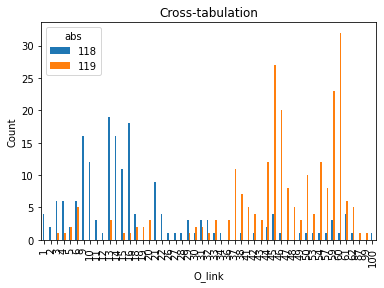

In [27]:
import matplotlib.pyplot as plt

cross_table.plot(kind="bar")
plt.xlabel('O_link')
plt.ylabel('Count')
plt.title('Cross-tabulation')
plt.show()


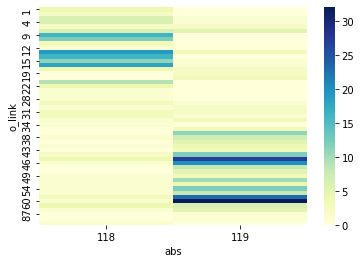

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cross_table, annot=False, fmt="d", cmap="YlGnBu")
plt.show()


In [15]:
##### 同時推定コード #####
import pandas as pd 
import os
import datetime
import numpy as np
from datetime import timedelta 
import csv
import time
import math
from scipy.stats import norm
from scipy.optimize import minimize

start_time = time.time()
print('start!')

####### reading data #######
# 実態リンクのうち片方向のリンクのみ入れたもの．観測モデルに使う．観測モデルでは仮想リンクや吸収リンクは関係ない上，グラフの向きも判定できないので．各リンクidに+1したものが逆方向リンクに対応
df_link_odds = pd.read_csv("/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link/shibuya_link_pre_odds.csv")
l = len(df_link_odds)

# ここには仮想リンクと吸収リンクを入れている
df_link_integrated = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link/shibuya_link_pre_integrated.csv')
L = len(df_link_integrated)

# 17:00-17:15からさらに絞ったデータを使用
search_folder = "/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20221218_17/quater_address750"
file_list = list(os.listdir(search_folder))

# ここは常に変わらない
df_node = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_node.csv')
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')

###### 各linkのoとdの座標を入れておく配列 ######
oddslink_loc_array = [] # 空リストを用意
for i in range(len(df_link_odds)):
    linkid = df_link_odds.loc[i, 'linkid']
    O = df_link_odds.loc[i, 'O']
    D = df_link_odds.loc[i, 'D']

    x_o = df_node[df_node['nodeid'] == O]['x'].iloc[0]
    y_o = df_node[df_node['nodeid'] == O]['y'].iloc[0]
    z_o = df_node[df_node['nodeid'] == O]['floor'].iloc[0] * 1000
    o_loc = np.array([x_o, y_o, z_o])

    x_d = df_node[df_node['nodeid'] == D]['x'].iloc[0]
    y_d = df_node[df_node['nodeid'] == D]['y'].iloc[0]
    z_d = df_node[df_node['nodeid'] == D]['floor'].iloc[0] * 1000 # これでseriesではなく値として抽出できるはず
    d_loc = np.array([x_d, y_d, z_d])

    loc_tuple = (o_loc, d_loc)

    oddslink_loc_array.append(loc_tuple) # oddslink_loc_array[linkid//2][0]がlinkidのonode, [1]がdnode，[2]が中点，，，，

###### ビーコンとリンク線分の最短距離返す関数 ######
def shortest_distance_to_segment(p1, p2, x):
    p1 = np.array(p1)
    p2 = np.array(p2)
    x = np.array(x)
    
    segment = p2 - p1
    v1 = x - p1
    v2 = x - p2
    
    # 垂直ベクトルを計算
    v = v1 - np.dot(v1, segment) / np.dot(segment, segment) * segment
    
    # 垂直ベクトルのノルム（距離）を求める
    distance = np.linalg.norm(v)
    
    # 線分の範囲内であるかチェック
    dot_product = np.dot(v1, segment)
    if dot_product < 0:
        return np.linalg.norm(x - p1)
    elif dot_product > np.dot(segment, segment):
        return np.linalg.norm(x - p2)
    else:
        return distance

###### d_arrayの用意 ######
d_array = np.zeros((len(df_link_odds), len(df_ble))) # 各リンク(奇数側)とbleビーコンとの距離配列

for i in range(len(df_link_odds)):
    p_o = oddslink_loc_array[i][0] # o座標 # i=1の時
    p_d = oddslink_loc_array[i][1] # d座標

    for j in range(len(df_ble)):
        x_ap = df_ble.loc[j, 'x']
        y_ap = df_ble.loc[j, 'y']
        z_ap = df_ble.loc[j, 'floor']*1000 # zの値をめちゃ大きくすることで，階を挟んだ電波捕捉を捨象（階の厳密な高さが不明なのと，床板・天井版による電波遮蔽を考慮するため）．階が同じなら0になるので変な影響はない
        p_ap = np.array([x_ap, y_ap, z_ap])

        d_array[i, j] = shortest_distance_to_segment(p_o, p_d, p_ap)

###### d_node_arrayの用意 ######
d_node_array = np.zeros((len(df_node), len(df_node))) # d_node_arrayのi行j列がnode i+1とnode j+1の間の距離となるように計算

for i in range(len(df_node)):
    xi = df_node.loc[i, 'x']
    yi = df_node.loc[i, 'y']
    zi = df_node.loc[i, 'floor']
    i_loc = np.array([xi, yi, zi])
    
    for j in range(len(df_node)):
        xj = df_node.loc[j, 'x']
        yj = df_node.loc[j, 'y']
        zj = df_node.loc[j, 'floor']
        j_loc = np.array([xj, yj, zj])

        d_node_array[i, j] = np.linalg.norm(i_loc - j_loc)

####### リンク接続行列（無向） ####### 
def I_nod(link_data): 
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        O = link_data.loc[i, 'O'] # 当該linkのOnode
        D = link_data.loc[i, 'D'] # Dnode
        for j in range(n):
            if ((link_data.loc[j, 'O'] == O) or (link_data.loc[j, 'O'] == D)) or (link_data.loc[j, 'D'] == O) or (link_data.loc[j, 'D'] == D): 
                I[i, j] = 1
    return(I)

####### リンク接続行列（有向） ####### 
def I_withd(link_data): # integratedを読み込む想定
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        D = link_data.loc[i, 'D']
        for j in range(n):
            if link_data.loc[j, 'O'] == D: # DnodeをOnodeとするリンクを1にしている
                I[i, j] = 1
    return(I)

###### （無向）接続行列 ###### 
Ind = I_nod(df_link_odds) 

###### （有向）接続行列 ######
Id = I_withd(df_link_integrated) 

###### 観測モデル内で使うためのデータ準備 ####### 
# 改札ノードのうち吸着ノードに繋がっているノード（流用可）
gate_node = [33, 36, # 1Fハチ公
            21, # 3F中央
            26, 27] # 1F南

# これは定義的には「仮想リンク」に接続するリンクたち」，つまりd_nodeがgate_nodeに一致するようなlinkのlinkidのリストにすればいい
gate_link = list(df_link_odds[df_link_odds['D'].isin(gate_node)]['linkid']) # isinを覚えよう！！！
"""
gate_link = [59, 61, # 1F南
            43, 47, 53, # 1Fハチ公
            35, 37] # 3F中央
"""

non_gate_link = list(df_link_odds[~df_link_odds['D'].isin(gate_node)]['linkid']) # ~をつけるとbool値が逆転


start!


In [16]:
print(gate_link)
print(non_gate_link)

[35, 37, 43, 47, 53, 59, 61]
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 39, 41, 45, 49, 51, 55, 57, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [17]:
home_link = df_link_odds[df_link_odds['home'] == 1]['linkid'].to_list()
staire_link = df_link_odds[df_link_odds['staire'] == 1]['linkid'].to_list()

print(home_link)
print(staire_link)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
[71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [18]:
all_gate_link = df_link_odds[(df_link_odds['minami_gate'] == 1) |(df_link_odds['chuo_gate'] == 1) |(df_link_odds['hachiko_gate'] == 1)]
non_gate_link = list(all_gate_link[~all_gate_link['D'].isin(gate_node)]['linkid']) # ~をつけるとbool値が逆転

print(non_gate_link)

[31, 33, 39, 41, 45, 49, 51, 55, 57, 63, 65, 67, 69]


In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt

test_list = [1, 0, 0, 1, 0, 6, 2, 0, 0, 0]
sum = np.sum(test_list)
test_list2 = [i/sum for i in test_list]
####### test_list2を可視化

#test_list_exp = [math.exp(i)/(math.exp(1)-1) for i in test_list2] # 普通のexpでよくね→だめ
test_list_edited = [i**2 for i in test_list2]
sumexp = np.sum(test_list_edited)
test_edited = [i/sumexp for i in test_list_edited] # 指数関数に変換した後で正規化
####### test_exp2を可視化

sumexp2 = np.sum(test_edited) # 1のはず

print(test_list2)
print(test_edited)
#print(sum2)
print(sumexp2)
#print(sumexp2)

[0.1, 0.0, 0.0, 0.1, 0.0, 0.6, 0.2, 0.0, 0.0, 0.0]
[0.02380952380952381, 0.0, 0.0, 0.02380952380952381, 0.0, 0.857142857142857, 0.09523809523809525, 0.0, 0.0, 0.0]
0.9999999999999999


In [5]:
import pandas as pd 
df = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11072.csv')
print(df.iloc[:, 3:84])


        1    2    3    4         5    6    7         8    9   10  ...   72  \
0     0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
1     0.0  0.0  0.0  0.0  0.142857  0.0  0.0  0.142857  0.0  0.0  ...  0.0   
2     0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
3     0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
4     0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
...   ...  ...  ...  ...       ...  ...  ...       ...  ...  ...  ...  ...   
9296  0.0  0.0  0.5  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
9297  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
9298  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
9299  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   
9300  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  ...  0.0   

       73   74   75   76   77   78   79   80   81  
0     0.0  

In [6]:
### Mtest2にnonzeroのカウントと最大観測確率のリンクを入れる
import pandas as pd 
df = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11072.csv')

df['nmeasured'] = df.iloc[:, 3:84].apply(lambda row: row[row != 0].count(), axis = 1) # applyはnumpyよりずっと遅いがforよりはマシなので覚えよう
df['maxlink'] = df.iloc[:, 3:84].idxmax(axis=1) 
print(df)
df.to_csv('/Users/takahiromatsunaga/res2023/test/Mtest11072_edited.csv')

      Unnamed: 0  user_id  timestep    1    2    3    4         5    6    7  \
0              0      6.0      29.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
1              1      6.0      30.0  0.0  0.0  0.0  0.0  0.142857  0.0  0.0   
2              2      6.0      31.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
3              3      6.0      32.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
4              4      6.0      33.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
...          ...      ...       ...  ...  ...  ...  ...       ...  ...  ...   
9296        9296  16217.0      86.0  0.0  0.0  0.5  0.0  0.000000  0.0  0.0   
9297        9297  16217.0      87.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
9298        9298  16217.0      88.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
9299        9299  16217.0      89.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   
9300        9300  16217.0      90.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   

      ...   75   76   77   78   79   80   81  absor

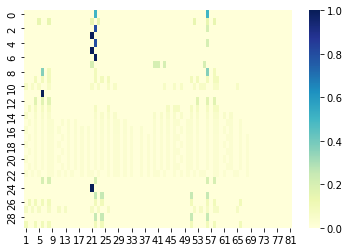

In [10]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11072.csv')
df_part = df.iloc[:30, 3:84]
sns.heatmap(df_part, annot=False, fmt="d", cmap="YlGnBu")
plt.show()

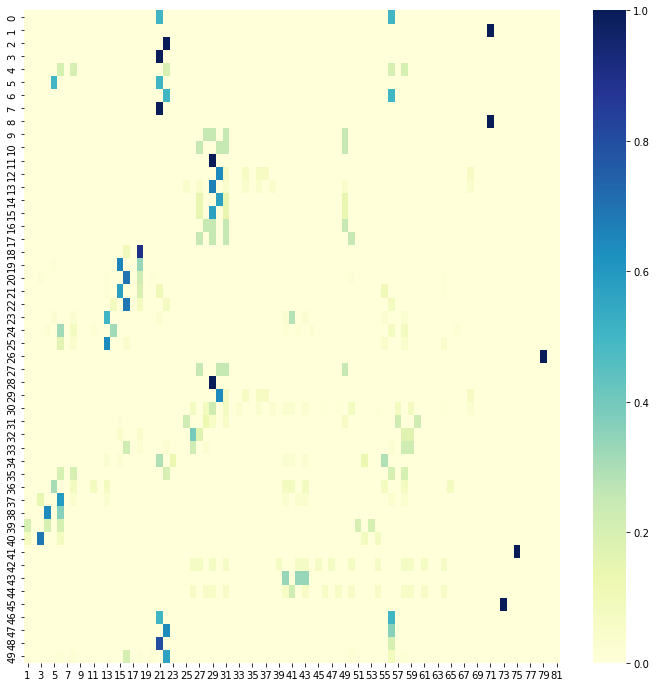

In [13]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11074.csv')
df_part = df.iloc[:50, 3:84]

plt.figure(figsize=(12, 12))  # ここでサイズを調整します

sns.heatmap(df_part, annot=False, fmt="d", cmap="YlGnBu")
plt.show()

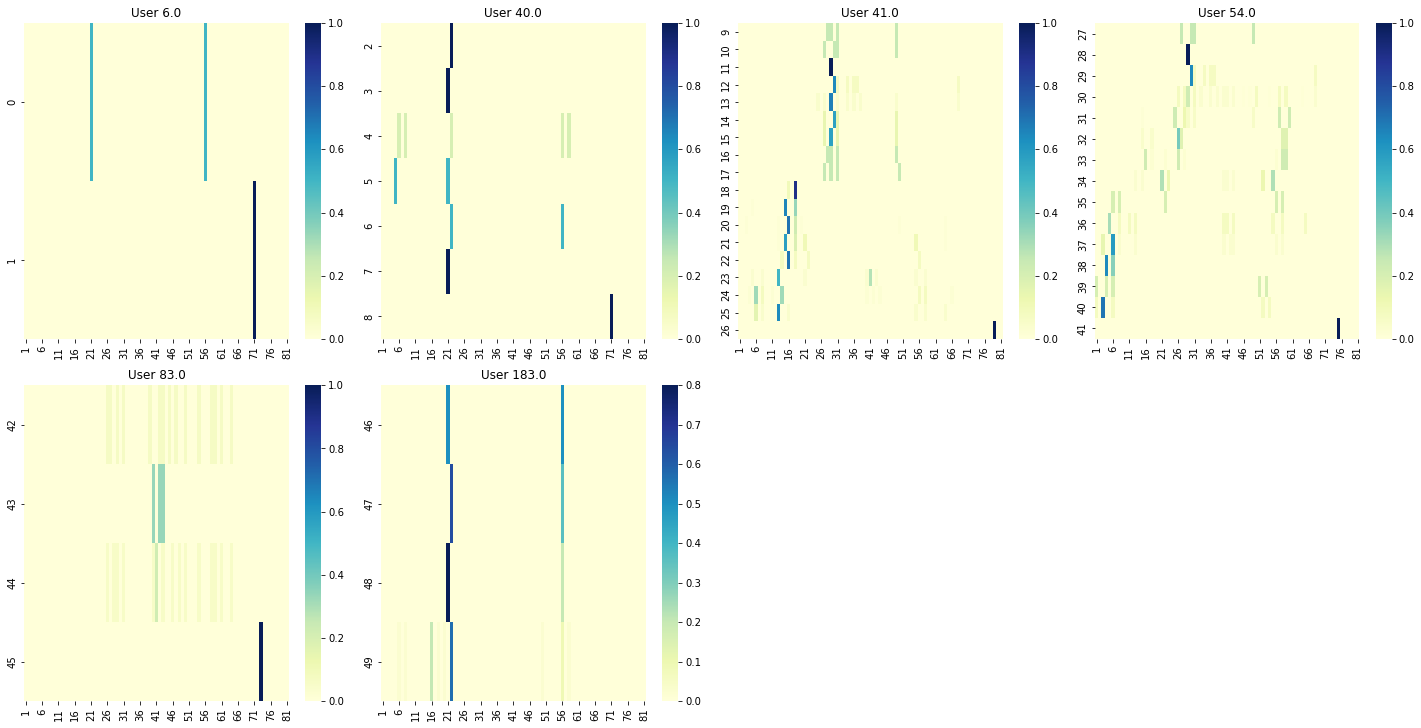

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# データを読み込む
df_origine = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11074.csv')
df = df_origine.head(50)
# useridでグループ化
data_list = list(df.groupby('user_id'))
# ヒートマップのサイズを調整
plt.figure(figsize=(20, 20))

# 各ユーザーごとにヒートマップを描画し、subplotを使用して配置
for i, (user, user_data) in enumerate(data_list):
    plt.subplot(4, 4, i+1)  # グラフを10x5のグリッドに配置 (ユーザーごとに調整)
    sns.heatmap(user_data.iloc[:, 3:84], annot=False, fmt="d", cmap="YlGnBu")
    plt.title(f'User {user}')

# グラフを表示
plt.tight_layout()  # グラフが重ならないように調整
plt.show()

start!


/var/folders/1p/_62pxgbn5kg837b06pfnvkdw0000gn/T/ipykernel_24327/2228341889.py:309: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  judge[selected_linkid] = 1


観測人数は576人で，そのうち改札吸着が256人，ホーム吸着が320人


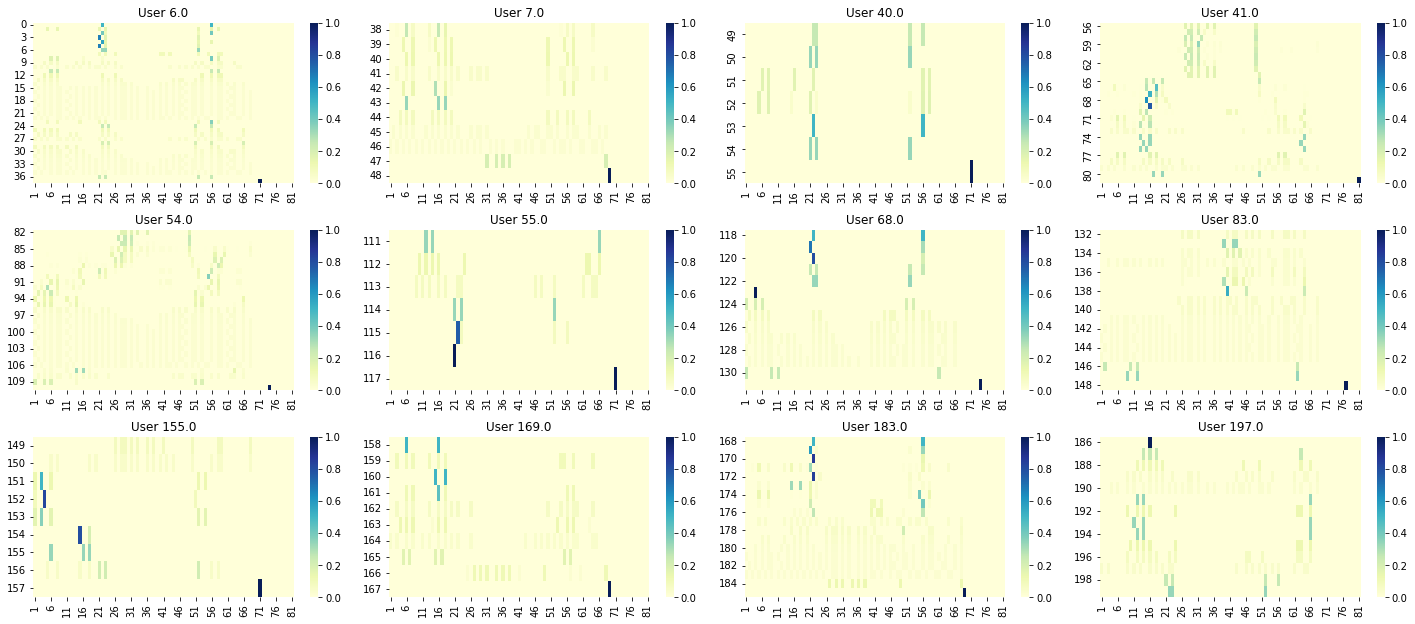

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
##### 同時推定コード #####
import pandas as pd 
import os
import datetime
import numpy as np
from datetime import timedelta 
import csv
import time
import math
from scipy.stats import norm
from scipy.optimize import minimize

start_time = time.time()
print('start!')

####### reading data #######
df_link_odds = pd.read_csv("/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link/shibuya_link_post_odds.csv")
l = len(df_link_odds)

df_link_integrated = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link/shibuya_link_post_integrated.csv')
L = len(df_link_integrated)

search_folder = "/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/quater_address750"
file_list = list(os.listdir(search_folder))

df_node = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_node.csv')
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')

###### 各linkのoとdの座標を入れておく配列 ######
oddslink_loc_array = [] # 空リストを用意
for i in range(len(df_link_odds)):
    linkid = df_link_odds.loc[i, 'linkid']
    O = df_link_odds.loc[i, 'O']
    D = df_link_odds.loc[i, 'D']

    x_o = df_node[df_node['nodeid'] == O]['x'].iloc[0]
    y_o = df_node[df_node['nodeid'] == O]['y'].iloc[0]
    z_o = df_node[df_node['nodeid'] == O]['floor'].iloc[0] * 1000
    o_loc = np.array([x_o, y_o, z_o])

    x_d = df_node[df_node['nodeid'] == D]['x'].iloc[0]
    y_d = df_node[df_node['nodeid'] == D]['y'].iloc[0]
    z_d = df_node[df_node['nodeid'] == D]['floor'].iloc[0] * 1000 # これでseriesではなく値として抽出できるはず
    d_loc = np.array([x_d, y_d, z_d])

    loc_tuple = (o_loc, d_loc)

    oddslink_loc_array.append(loc_tuple) # oddslink_loc_array[linkid//2][0]がlinkidのonode, [1]がdnode，[2]が中点，，，，

###### ビーコンとリンク線分の最短距離返す関数 ######
def shortest_distance_to_segment(p1, p2, x):
    p1 = np.array(p1)
    p2 = np.array(p2)
    x = np.array(x)
    
    segment = p2 - p1
    v1 = x - p1
    v2 = x - p2
    
    # 垂直ベクトルを計算
    v = v1 - np.dot(v1, segment) / np.dot(segment, segment) * segment
    
    # 垂直ベクトルのノルム（距離）を求める
    distance = np.linalg.norm(v)
    
    # 線分の範囲内であるかチェック
    dot_product = np.dot(v1, segment)
    if dot_product < 0:
        return np.linalg.norm(x - p1)
    elif dot_product > np.dot(segment, segment):
        return np.linalg.norm(x - p2)
    else:
        return distance

###### d_arrayの用意 ######
d_array = np.zeros((len(df_link_odds), len(df_ble))) # 各リンク(奇数側)とbleビーコンとの距離配列

for i in range(len(df_link_odds)):
    p_o = oddslink_loc_array[i][0] # o座標 # i=1の時
    p_d = oddslink_loc_array[i][1] # d座標

    for j in range(len(df_ble)):
        x_ap = df_ble.loc[j, 'x']
        y_ap = df_ble.loc[j, 'y']
        z_ap = df_ble.loc[j, 'floor']*1000 # zの値をめちゃ大きくすることで，階を挟んだ電波捕捉を捨象（階の厳密な高さが不明なのと，床板・天井版による電波遮蔽を考慮するため）．階が同じなら0になるので変な影響はない
        p_ap = np.array([x_ap, y_ap, z_ap])

        d_array[i, j] = shortest_distance_to_segment(p_o, p_d, p_ap)

###### d_node_arrayの用意 ######
d_node_array = np.zeros((len(df_node), len(df_node))) # d_node_arrayのi行j列がnode i+1とnode j+1の間の距離となるように計算

for i in range(len(df_node)):
    xi = df_node.loc[i, 'x']
    yi = df_node.loc[i, 'y']
    zi = df_node.loc[i, 'floor']
    i_loc = np.array([xi, yi, zi])
    
    for j in range(len(df_node)):
        xj = df_node.loc[j, 'x']
        yj = df_node.loc[j, 'y']
        zj = df_node.loc[j, 'floor']
        j_loc = np.array([xj, yj, zj])

        d_node_array[i, j] = np.linalg.norm(i_loc - j_loc)

####### リンク接続行列（無向） ####### 
def I_nod(link_data): 
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        O = link_data.loc[i, 'O'] # 当該linkのOnode
        D = link_data.loc[i, 'D'] # Dnode
        for j in range(n):
            if ((link_data.loc[j, 'O'] == O) or (link_data.loc[j, 'O'] == D)) or (link_data.loc[j, 'D'] == O) or (link_data.loc[j, 'D'] == D): 
                I[i, j] = 1
    return(I)

####### リンク接続行列（有向） ####### 
def I_withd(link_data): # integratedを読み込む想定
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        D = link_data.loc[i, 'D']
        for j in range(n):
            if link_data.loc[j, 'O'] == D: # DnodeをOnodeとするリンクを1にしている
                I[i, j] = 1
    return(I)

###### （無向）接続行列 ###### 
Ind = I_nod(df_link_odds) 

###### （有向）接続行列 ######
Id = I_withd(df_link_integrated) 

###### 観測モデル内で使うためのデータ準備 ####### 
gate_node = [33, 36, # 1Fハチ公
            21, # 3F中央
            26, 27] # 1F南

gate_link = list(df_link_odds[df_link_odds['D'].isin(gate_node)]['linkid']) # isinを覚えよう！！！
all_gate_link = df_link_odds[(df_link_odds['minami_gate'] == 1) |(df_link_odds['chuo_gate'] == 1) |(df_link_odds['hachiko_gate'] == 1)]
non_gate_link = list(all_gate_link[~all_gate_link['D'].isin(gate_node)]['linkid']) # ~をつけるとbool値が逆転

"""
gate_link = [59, 61, # 1F南
            43, 47, 53, # 1Fハチ公
            35, 37] # 3F中央
# 改札リンクのうち仮想リンクに接続しないリンク
non_gate_link = [31, 33, 39, # 3F中央
                41, 45, 49, 51, 55, 57, # 1Fハチ公 link45は検討
                63, 65, 67, 69] # 1F南 
"""

home_node = df_node[df_node['floor'] == 20.5]['nodeid'].to_list()
home_link = df_link_odds[df_link_odds['home'] == 1]['linkid'].to_list()
staire_link = df_link_odds[df_link_odds['staire'] == 1]['linkid'].to_list()

# 仮想リンクとの接続関係（流用不可）
# pre
#virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 35, 37, 43, 47, 53, 59, 61],
#                           [106, 107, 108, 108, 109, 109, 110, 111, 112, 113, 114, 114, 115, 116, 117, 103, 103, 101, 101, 102, 104, 105]])

# under
# virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 21, 23, 29, 33, 37, 41, 43],
#                           [78, 79, 80, 80, 81, 82, 83, 84, 85, 75, 75, 73, 73, 74, 76, 77]]) # 103, 103, 101, 101, 102, 104, 105]])

# post # 29を入れ忘れた．69に接続させます
virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 21, 27, 29, 31, 35, 39, 41],
                           [74, 75, 76, 76, 77, 78, 79, 80, 81, 71, 69, 69, 69, 70, 72, 73]]) # 103, 103, 101, 101, 102, 104, 105]])

####### パラメタ初期設定 ####### 
x0 = np.zeros(2)
x0[0] = -1
x0[1] = -1
#x0[-1] = 0.99

####### 観測方程式 ###### 
def DDR(rssi, dens, x):
    return (10**((-rssi-50)/dens/0.1)) # x[0]は非零．RSSI0=-50は根拠なし

####### 観測モデルその1 ######
def measuring_model1(x): 

    measuring_result1 = pd.DataFrame(columns=['user_id'] + ['timestep'] + [str(i) for i in range(1, L-1)])

    for file_name in file_list:
    
        if file_name.endswith('.csv'):
            
            base_name = file_name.split('.')[0] # 数字部分のみ
            user_id = int(base_name) 
            
            file_path = os.path.join(search_folder, file_name)
            df = pd.read_csv(file_path) 
            
            # timestep数3以下の場合スキップ
            timestep_count = df['timestep'].nunique()
            if timestep_count <= 3:
                continue
            
            grouped = df.groupby('timestep') 
            df_list = [group for name, group in grouped]
            df_list = [mac_data.reset_index(drop=True) for mac_data in df_list]
            
            # res_unionの初期化．リンク数L-2+userd_id+timestepで119（preの場合）
            res_union = np.zeros(L)

            # timestep類の用意
            df_first = df_list[0]
            df_last = df_list[-1]
            first_ts = df_first.loc[0, 'timestep']
            last_ts = df_last.loc[0, 'timestep']
            prev_ts = first_ts - 1

            # 各timestepにおける観測確率の算定
            for i in range(timestep_count): 
                
                df_now = df_list[i] # timestep内の個別データの集合(dataframe)

                # 1timestep内での観測尤度を入れるための配列．後でres_unionに結合．各linkの観測確率を入れるので吸収以外のリンク数117（preの場合）
                res_t = np.zeros(L-2)

                now_ts = df_now.loc[0, 'timestep'] 

                # 連続してなければそこで次のuserに移行（連続してる部分までは取る）
                #if now_ts - prev_ts > 1:
                #    break
                
                while (now_ts - prev_ts) > 1: 
                    # i-1の観測結果はres_unionの一番最後の行．0, 1列はuseridとtimestepなので2列以降がリンク観測結果
                    prev_result = res_union[-1, 2:] 

                    # i-1で観測確率!=0のリンクを抽出
                    nonzero_indices = np.where(prev_result != 0)[0]     # index=linkid-1が得られる
                    prev_link = nonzero_indices + 1                     # これでprev_tsでの観測があったリンクのlinkidのリストが得られた

                    # 有効な接続リンクを抽出
                    link_candidates = set()                             # setは重複を許容しない
                    for candidate in prev_link:                         # それぞれの観測リンク（candidiateのこと，candidateはlinkid）に対して，接続するリンクのlinkidを得て，これをlink_candidatesに追加．
                        cand_column = Ind[:, candidate//2]              # candidate-1がcandidateのindex
                        cands_index = np.where(cand_column == 1)[0]     # candidateに接続するリンクcandsのindexの集合を得る．接続行列Indを参照
                        candidates = cands_index*2 + 1                  # linkidに戻す

                        for cand in candidates:
                            link_candidates.add(cand)

                    # これでlink_candidatesに観測されたリンクのlinkidが重複なく入った→リスト化→昇順並び替え（これでlinkidとindexを紐づけられる）
                    link_candidates = list(link_candidates)
                    link_candidates.sort()

                    # linkidからindexを得る（index = linkid-1）
                    cand_index = [int(x)-1 for x in link_candidates] 

                    # 判定用．連続の場合の処理をまねる（全リンクから吸収リンクを除いたL-2）
                    judge = np.zeros(L-2) 
                    index = np.array([i for i in range(L-2)]) 

                    mask = np.isin(index, cand_index)
                    judge[index[mask]] = 1
                    judge_sum = np.sum(judge)

                    if judge_sum == 0: # 接続行列がないリンクはないはずなので，実行されないはず
                        print('error!!')
                        link_probability = judge
                    if judge_sum != 0:
                        link_probability = judge/judge_sum

                    # t, userid追加してres_unionの一番下に追加する．以下連続の場合と同じ
                    time_step_array = np.array([prev_ts+1])
                    t_result = np.concatenate((time_step_array, link_probability))

                    user_id_array = np.array([user_id])
                    t_result_withid = np.concatenate((user_id_array, t_result))
                    #print(f'補正あり{prev_ts+1}')

                    res_union = np.vstack((res_union, t_result_withid))

                    prev_ts = prev_ts + 1 # 処理終わったらスタンプ更新

                # while抜けたらこっちに移る
                for j in range(len(df_now)): 
                    rssi = df_now.loc[j, 'RSSI'] 
                    dens = df_now.loc[j, 'dens']
                    ID = df_now.loc[j, 'ID']

                    ble_index_list = df_ble[df_ble['ID']==ID].index.tolist()    # index()はindexオブジェクトを返す！
                    ble_index = ble_index_list[0]                               # ble beaconのindex

                    # ddrの判定を一気に実行
                    ddr = DDR(rssi, dens, x)

                    condition = d_array[:, ble_index] <= ddr                    # d_arrayのbleindexの列の中でddrよりも値が小さいという条件（つまりddr内）
                    selected_indices = np.where(condition)                      # これがddr内認定されたlinkのindex．実際のlinkidはindex*2+1，全体で見た時のindexはindex*2
                    #print(type(selected_indices)) # tuple                      # 空のtupleはlen1になる．tuple[0]でちゃんといけるらしい(!!!!!?)
                        
                    # ddr以下を満たすlinkがなかった場合，最もdが小さいlinkを入れてselected_indicesとして更新
                    if len(selected_indices[0]) == 0: 
                        min_value = np.min(d_array[:, ble_index])
                        selected_indices = np.where(d_array[:, ble_index] == min_value)[0]  # 最小値と一致するすべての要素のインデックスを取得→where!!
                        
                    selected_linkid = [i*2 for i in selected_indices] # 該当するlinkの全体でのindex
                        
                    # judge配列の初期化．後でres_unionとくっつけるがjudgeはlinkの情報のみ．その後でuser_idとtimestepが足される
                    judge = np.zeros(L-2)
                    judge[selected_linkid] = 1 
                        
                    res_t = np.vstack((res_t, judge))
                    
                # このtimestepでの全データを捜索終了．res_tには各データでDDR内判定されたリンクのところが1になっている
                judge_counts = np.sum(res_t, axis=0) 
                judge_sum = np.sum(judge_counts)

                if judge_sum == 0:
                    print('error!!') # judge_counts=0にはならないはず
                    link_probability = judge_counts
                if judge_sum != 0:
                    #link_probability = judge_counts/judge_sum # 上手い方法わからずとりあえず等配分．numpy同士なので割れている．listだと割れない
                    link_probability0 = [i**2 for i in judge_counts] # 重みづけにグラデーションつける
                    sum = np.sum(link_probability0)
                    link_probability1 = [i/sum for i in link_probability0]
                    link_probability = np.array(link_probability1)

                # 要素数は1．timestepの値をlink_probabilityの先頭に入れる．そのためにはnumpy配列化してから挿入する必要がある
                time_step_array = np.array([now_ts])

                # time_step，useridを記録
                t_result = np.concatenate((time_step_array, link_probability))
                user_id_array = np.array([user_id])
                t_result_withid = np.concatenate((user_id_array, t_result))
                #print(f'補正なし{now_ts}') 

                res_union = np.vstack((res_union, t_result_withid))

                prev_ts = now_ts # 処理終わったらスタンプ更新，絶対に次のdfに進む

            # ここまでで全timestepに対して結果が出て，res_unionに入ってる．初期設定で入れておいた0の列を消去
            res_union = np.delete(res_union, 0, axis=0)
            
            # res_unionをdataframe化
            df_result = pd.DataFrame(data=res_union)

            # columnsを設定．第0列目はuser_id, 1列目はtなので，link1~117の尤度の情報が入ってるのはindex2~118列
            df_result.columns = ['user_id'] + ['timestep'] + [str(i) for i in range(1, L-1)] 

            # 確率最大リンクが複数ある場合，idxmaxメソッドは見つかった最初のindexを返す．linkの設定で階段は後ろの方に設定しておいたので，コンコースかホーム上のリンクが優先される．よって階段とホームの尤度が最大であったときもホームを採用するから問題なし
            o_link = df_result.iloc[0, 2:L].idxmax() 
            #d_link = df_result.iloc[timestep_count-1, 2:L].idxmax()
            d_link = df_result.iloc[-1, 2:L].idxmax()

            o_link = int(o_link)
            d_link = int(d_link)
            
            if (o_link in staire_link) or (d_link in staire_link):  # o_linkあるいはd_linkが階段リンクのケースは落とす
                continue
            if d_link in non_gate_link:                             # dがnon_gate_linkの場合落とす→これの条件がきつすぎる?
                continue
            if (o_link in home_link) and (d_link in home_link):     # odともにhomeのケースは落とす→機能してる
                continue
            if (o_link in all_gate_link) and (d_link in all_gate_link): # これきいてない
                continue
            # if d_link in home_link:                                 # dがhomelinkだったら落とす
            #     continue
            # if d_link in gate_link:
                # continue
            measuring_result1 = pd.concat([measuring_result1, df_result], ignore_index=True) # ここまでであるuserに対する処理が終了，全体のdataframeに情報追加 # count += 1 

    return measuring_result1


####### 観測モデルその2 ######
def measuring_model2(x):
    measuring_result1 = measuring_model1(x) # 第一段階のアウトプット．列カラムはuserid, timestep, link1~117の観測確率

    # measuring_result2の初期化，最初はNaN
    measuring_result2 = pd.DataFrame(columns=['user_id'] + ['timestep'] + [str(i) for i in range(1, L-1)] + ['absorption']) 

    # user_idでgroupわけしdataframeをリスト化（いつも通り）
    grouped = measuring_result1.groupby('user_id')
    df_list = [group for name, group in grouped]
    df_list = [data.reset_index(drop = True) for data in df_list]

    count = 0
    gateend = 0
    homeend = 0

    for i in range(len(df_list)): # 処理は全部個人ごとに行ってしまい，後でdataframeを再度まとめる．
        
        df = df_list[i]
        n = len(df) # 最後の行はn-1

        last_ts = df.loc[n-1, 'timestep'] # -1だとダメだったがn-1にしたらOKになった
        last_ts = int(last_ts)
        userid = df.loc[0, 'user_id']

        # d_linkを取得（一番最後のデータから）．列名なのでintに変換する
        d_link = df.iloc[-1, 2:L].idxmax()
        d_link = int(d_link) # linkid

        # 仮想リンク用の行を下に追加．結構面倒
        new_row = pd.Series([0] * len(df.columns), index=df.columns)
        df = df.append(new_row, ignore_index=True) # 追加してるのがseriesだったのでconcatだとおかしなことになってた模様
        #df = pd.concat([df, new_row], ignore_index=True) # サーバでやるならこっち！
        
        df.loc[n, 'user_id'] = userid 
        df.loc[n, 'timestep'] = last_ts+1 
        #print(d_link)
        # d_linkに対応する仮想リンクに確率1を与える
        is_equal = (virtual_connect[0] == d_link) # bool配列
        equal_columns = np.where(is_equal)[0] # これはリストで返ってくる
        #print(equal_columns) # これが空になっている
        column = equal_columns[0] # intに
        virtual_link = virtual_connect[1, column] # これで対応する仮想リンクのlinkidが得られるはず(int)
        
        # virtual_linkはlinkidなのでcolumnsに変換するには+1．measuring_result1は0: user_id, 1: timestep, 2~118がlink1~117なので
        column_num = virtual_link + 1 
        df.iloc[n, column_num] = 1 # 対応する仮想リンクの列の値を1に
        
        #### 以上でリンクに時系列の観測確率が入り，吸収状態の情報も入った．あとはお尻から次のtimestep（timestepは1からじゃない）での観測確率が最大のリンクのo_nodeに近い方をとる．# こうすることで回遊とか彷徨い行動をカットしないで済む（それだけのためである）
        
        for j in range(n-1, -1, -1): # 最終観測リンク(index = n-1，index nが仮想リンクのため)から先頭まで．tsがindexになってる．last_tsをintにするの忘れない（前）# 次のtimestep(ts+1)で最も観測確率の高かったリンクのlinkidを取得
            next_maxlink = df.iloc[j+1, 2:L].idxmax() 
            next_maxlink = int(next_maxlink) # int変換

            # df_link_intregratedを参照してmaxlinkのo_nodeを取得
            maxlink_onode = df_link_integrated[df_link_integrated['linkid'] == next_maxlink]['O'].iloc[0]

            # preなら1-99の奇数，postなら1-67の奇数，underなら1-71の奇数
            for k in range(1, 68, 2): # df_link_integratedを参照してlink kとlink k+1のd_nodeを取得し，o_nodeとの距離を比較
                klink_dnode = df_link_integrated.loc[k-1, 'D'] #Dnodeのnodeidが得られる
                k1link_dnode = df_link_integrated.loc[k, 'D'] # kと逆方向の偶数リンクのDnodeのnodeid

                d_k = d_node_array[maxlink_onode - 1, klink_dnode - 1]
                d_k1 = d_node_array[maxlink_onode - 1, k1link_dnode - 1]
                if d_k <= d_k1: 
                    continue
                if d_k > d_k1: # ならdf[k]とdf[k+1]を入れ替える．kはlinkidで今dfはuser_idとtimestepを持つからlink kのindexはk+1(link1はindex2, ,,,)，link k+1はindexk+2
                    df.iloc[j, k+2] = df.iloc[j, k+1] # k+1にkの観測確率をあげる
                    df.iloc[j, k+1] = 0 # kの方は0になる
                        
        # 最後にabsorption列追加 
        df['absorption'] = 0
        if d_link in gate_link:
            df['absorption'] = 82  # postなら82, underなら86      
            gateend += 1
        if d_link in home_link:
            df['absorption'] = 83
            homeend += 1

        # ここまででこのユーザに対して補正が完了．付け足していく
        #measuring_result2 = measuring_result2.append(df)
        measuring_result2 = pd.concat([measuring_result2, df], ignore_index = True)

        count += 1
    
    # 最後にindexをリセット
    measuring_result2.reset_index(drop = True)
    measuring_result2 = measuring_result2.fillna(0)
        
    # アウトプットは，measuring_result1に各ユーザの仮想timestepが増えたもの & 基本的な形は同じ．これを尤度関数の時に呼び出す
    print(f'観測人数は{count}人で，そのうち改札吸着が{gateend}人，ホーム吸着が{homeend}人')
    return(measuring_result2)

df_origine = measuring_model2(x0)
# データを読み込む
#df_origine = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11072.csv')
df = df_origine.head(200)
# useridでグループ化
data_list = list(df.groupby('user_id'))
# ヒートマップのサイズを調整
plt.figure(figsize=(20, 20))

# 各ユーザーごとにヒートマップを描画し、subplotを使用して配置
for i, (user, user_data) in enumerate(data_list):
    plt.subplot(7, 4, i+1)  # グラフをM*Nのグリッドに配置 (ユーザーごとに調整)
    sns.heatmap(user_data.iloc[:, 2:83], annot=False, fmt="d", cmap="YlGnBu")
    plt.title(f'User {user}')

# グラフを表示
plt.tight_layout()  # グラフが重ならないように調整
plt.show()

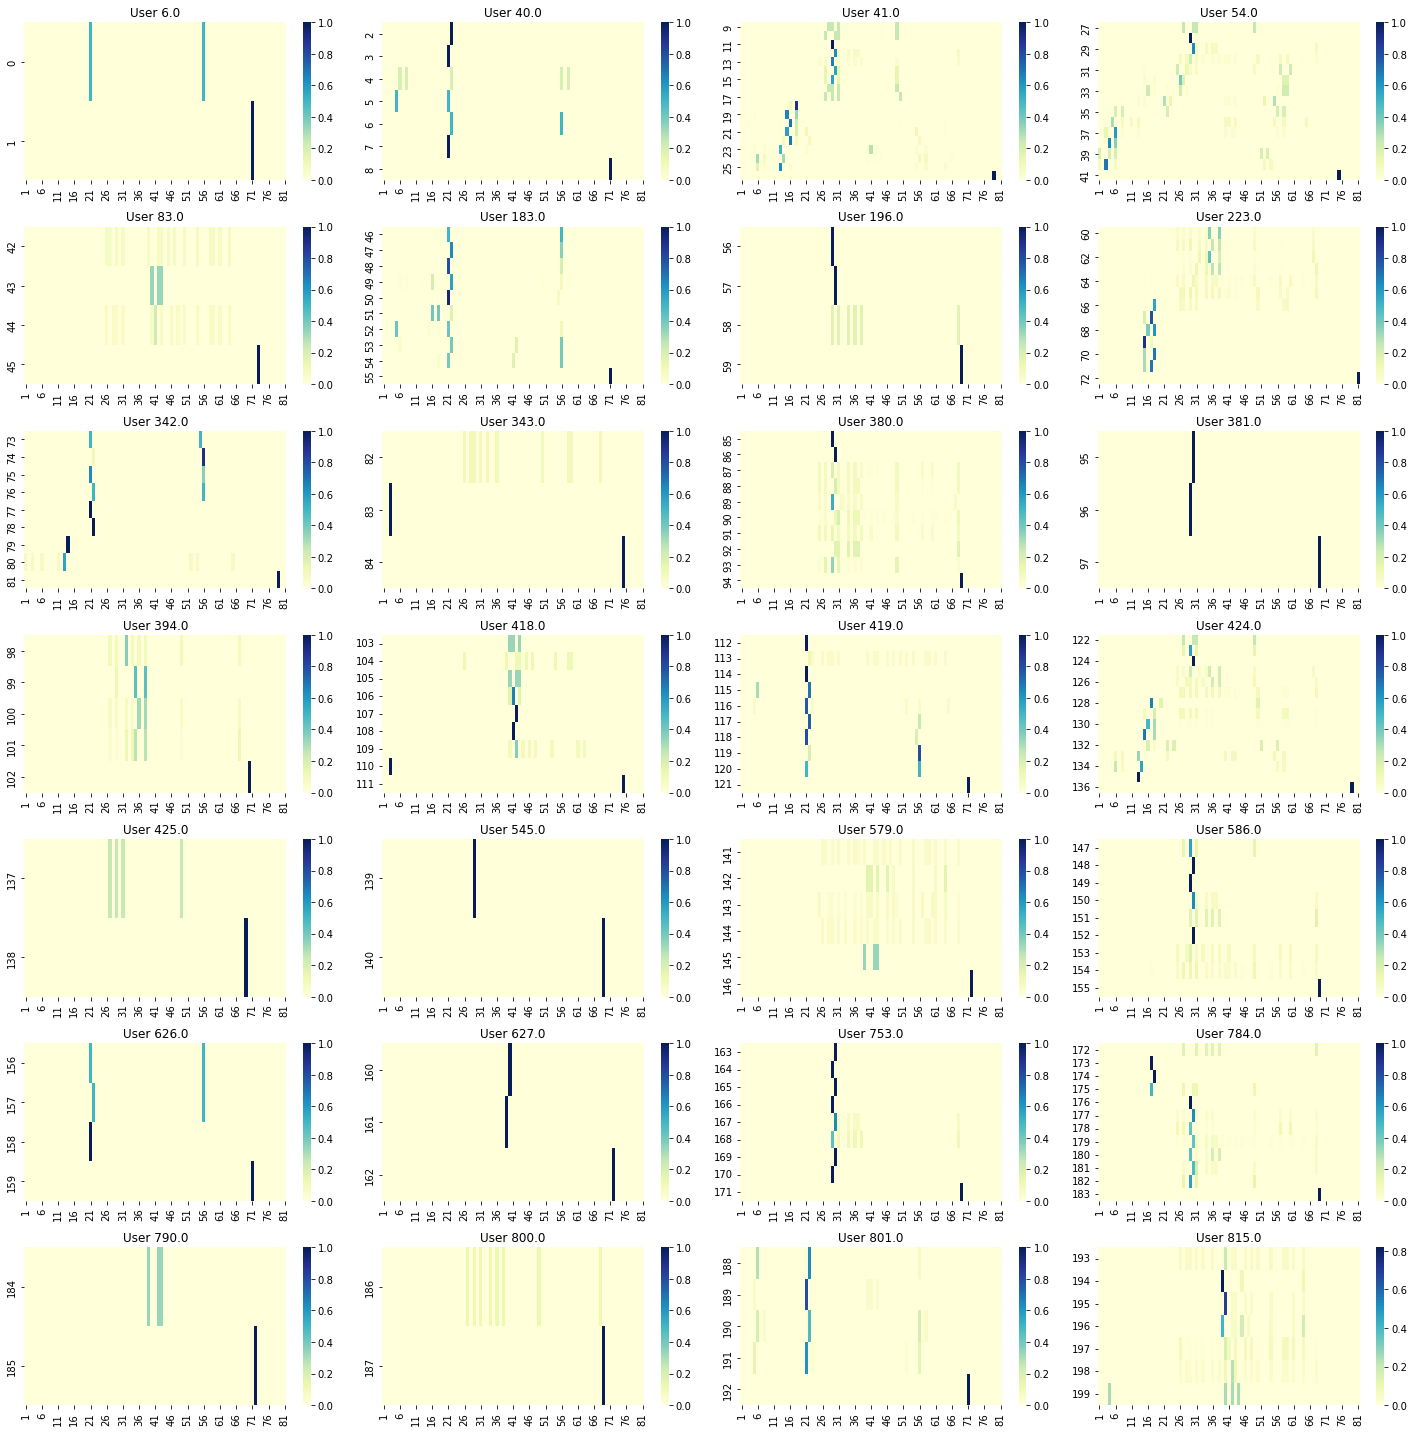

In [37]:

#df = measuring_model2(x0)
# データを読み込む
df_origine = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11074.csv')
df = df_origine.head(200)
# useridでグループ化
data_list = list(df.groupby('user_id'))
# ヒートマップのサイズを調整
plt.figure(figsize=(20, 20))

# 各ユーザーごとにヒートマップを描画し、subplotを使用して配置
for i, (user, user_data) in enumerate(data_list):
    plt.subplot(7, 4, i+1)  # グラフをM*Nのグリッドに配置 (ユーザーごとに調整)
    sns.heatmap(user_data.iloc[:, 3:84], annot=False, fmt="d", cmap="YlGnBu")
    plt.title(f'User {user}')

# グラフを表示
plt.tight_layout()  # グラフが重ならないように調整
plt.show()

start!


/var/folders/1p/_62pxgbn5kg837b06pfnvkdw0000gn/T/ipykernel_24327/2571545618.py:310: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  judge[selected_linkid] = 1


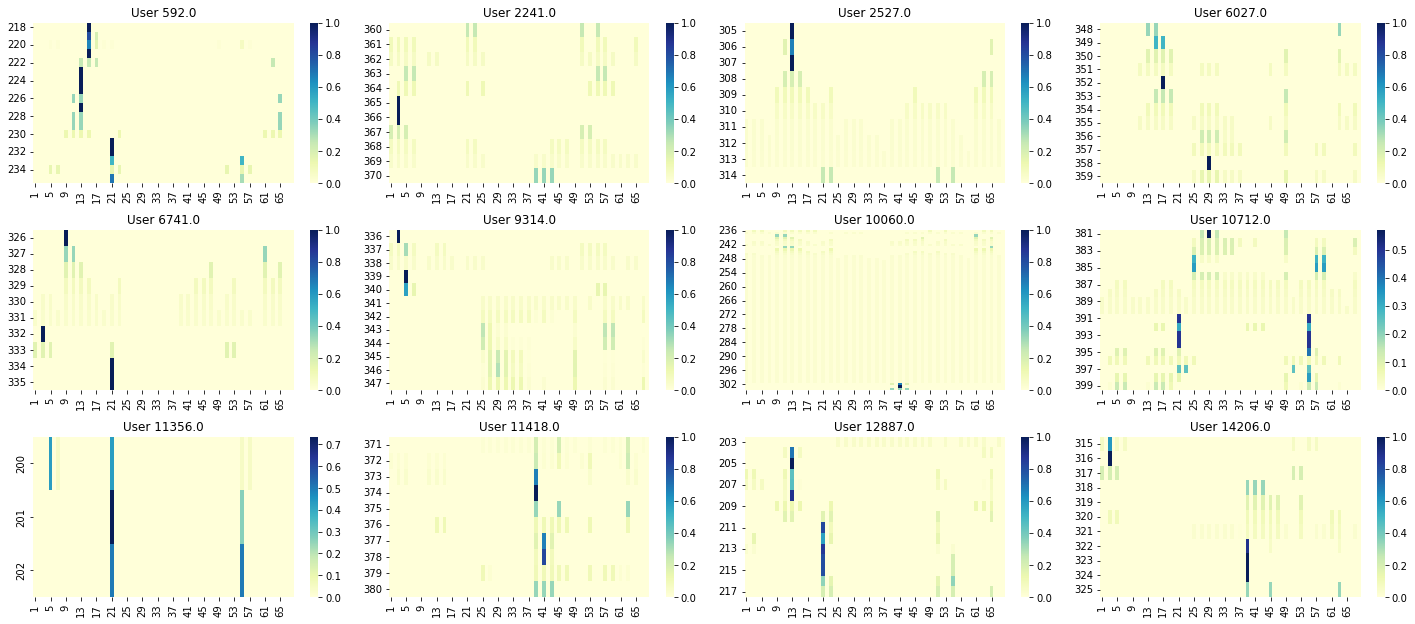

In [45]:
###### ver5に改良した

##### 同時推定コード #####
import pandas as pd 
import os
import datetime
import numpy as np
from datetime import timedelta 
import csv
import time
import math
from scipy.stats import norm
from scipy.optimize import minimize

start_time = time.time()
print('start!')

####### reading data #######
df_link_odds = pd.read_csv("/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link_corrected/shibuya_link_post_odds.csv")
l = len(df_link_odds)

df_link_integrated = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link_corrected/shibuya_link_post_integrated.csv')
L = len(df_link_integrated)

search_folder = "/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/quater_address750"
file_list = list(os.listdir(search_folder))

df_node = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_node.csv')
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')

###### 各linkのoとdの座標を入れておく配列 ######
oddslink_loc_array = [] # 空リストを用意
for i in range(len(df_link_odds)):
    linkid = df_link_odds.loc[i, 'linkid']
    O = df_link_odds.loc[i, 'O']
    D = df_link_odds.loc[i, 'D']

    x_o = df_node[df_node['nodeid'] == O]['x'].iloc[0]
    y_o = df_node[df_node['nodeid'] == O]['y'].iloc[0]
    z_o = df_node[df_node['nodeid'] == O]['floor'].iloc[0] * 1000
    o_loc = np.array([x_o, y_o, z_o])

    x_d = df_node[df_node['nodeid'] == D]['x'].iloc[0]
    y_d = df_node[df_node['nodeid'] == D]['y'].iloc[0]
    z_d = df_node[df_node['nodeid'] == D]['floor'].iloc[0] * 1000 # これでseriesではなく値として抽出できるはず
    d_loc = np.array([x_d, y_d, z_d])

    loc_tuple = (o_loc, d_loc)

    oddslink_loc_array.append(loc_tuple) # oddslink_loc_array[linkid//2][0]がlinkidのonode, [1]がdnode，[2]が中点，，，，

###### ビーコンとリンク線分の最短距離返す関数 ######
def shortest_distance_to_segment(p1, p2, x):
    p1 = np.array(p1)
    p2 = np.array(p2)
    x = np.array(x)
    
    segment = p2 - p1
    v1 = x - p1
    v2 = x - p2
    
    # 垂直ベクトルを計算
    v = v1 - np.dot(v1, segment) / np.dot(segment, segment) * segment
    
    # 垂直ベクトルのノルム（距離）を求める
    distance = np.linalg.norm(v)
    
    # 線分の範囲内であるかチェック
    dot_product = np.dot(v1, segment)
    if dot_product < 0:
        return np.linalg.norm(x - p1)
    elif dot_product > np.dot(segment, segment):
        return np.linalg.norm(x - p2)
    else:
        return distance

###### d_arrayの用意 ######
d_array = np.zeros((len(df_link_odds), len(df_ble))) # 各リンク(奇数側)とbleビーコンとの距離配列

for i in range(len(df_link_odds)):
    p_o = oddslink_loc_array[i][0] # o座標 # i=1の時
    p_d = oddslink_loc_array[i][1] # d座標

    for j in range(len(df_ble)):
        x_ap = df_ble.loc[j, 'x']
        y_ap = df_ble.loc[j, 'y']
        z_ap = df_ble.loc[j, 'floor']*1000 # zの値をめちゃ大きくすることで，階を挟んだ電波捕捉を捨象（階の厳密な高さが不明なのと，床板・天井版による電波遮蔽を考慮するため）．階が同じなら0になるので変な影響はない
        p_ap = np.array([x_ap, y_ap, z_ap])

        d_array[i, j] = shortest_distance_to_segment(p_o, p_d, p_ap)

###### d_node_arrayの用意 ######
d_node_array = np.zeros((len(df_node), len(df_node))) # d_node_arrayのi行j列がnode i+1とnode j+1の間の距離となるように計算

for i in range(len(df_node)):
    xi = df_node.loc[i, 'x']
    yi = df_node.loc[i, 'y']
    zi = df_node.loc[i, 'floor']
    i_loc = np.array([xi, yi, zi])
    
    for j in range(len(df_node)):
        xj = df_node.loc[j, 'x']
        yj = df_node.loc[j, 'y']
        zj = df_node.loc[j, 'floor']
        j_loc = np.array([xj, yj, zj])

        d_node_array[i, j] = np.linalg.norm(i_loc - j_loc)

####### リンク接続行列（無向） ####### 
def I_nod(link_data): 
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        O = link_data.loc[i, 'O'] # 当該linkのOnode
        D = link_data.loc[i, 'D'] # Dnode
        for j in range(n):
            if ((link_data.loc[j, 'O'] == O) or (link_data.loc[j, 'O'] == D)) or (link_data.loc[j, 'D'] == O) or (link_data.loc[j, 'D'] == D): 
                I[i, j] = 1
    return(I)

####### リンク接続行列（有向） ####### 
def I_withd(link_data): # integratedを読み込む想定
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        D = link_data.loc[i, 'D']
        for j in range(n):
            if link_data.loc[j, 'O'] == D: # DnodeをOnodeとするリンクを1にしている
                I[i, j] = 1
    return(I)

###### （無向）接続行列 ###### 
Ind = I_nod(df_link_odds) 

###### （有向）接続行列 ######
Id = I_withd(df_link_integrated) 

###### 観測モデル内で使うためのデータ準備 ####### 
gate_node = [33, 36, # 1Fハチ公
            21, # 3F中央
            26, 27] # 1F南

gate_link = list(df_link_odds[df_link_odds['D'].isin(gate_node)]['linkid']) # isinを覚えよう！！！
all_gate_link = df_link_odds[(df_link_odds['minami_gate'] == 1) |(df_link_odds['chuo_gate'] == 1) |(df_link_odds['hachiko_gate'] == 1)]
non_gate_link = list(all_gate_link[~all_gate_link['D'].isin(gate_node)]['linkid']) # ~をつけるとbool値が逆転

"""
gate_link = [59, 61, # 1F南
            43, 47, 53, # 1Fハチ公
            35, 37] # 3F中央
# 改札リンクのうち仮想リンクに接続しないリンク
non_gate_link = [31, 33, 39, # 3F中央
                41, 45, 49, 51, 55, 57, # 1Fハチ公 link45は検討
                63, 65, 67, 69] # 1F南 
"""

home_node = df_node[df_node['floor'] == 20.5]['nodeid'].to_list()
home_link = df_link_odds[df_link_odds['home'] == 1]['linkid'].to_list()
staire_link = df_link_odds[df_link_odds['staire'] == 1]['linkid'].to_list()

# 仮想リンクとの接続関係（流用不可）
# pre
#virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 35, 37, 43, 47, 53, 59, 61],
#                           [106, 107, 108, 108, 109, 109, 110, 111, 112, 113, 114, 114, 115, 116, 117, 103, 103, 101, 101, 102, 104, 105]])

# under
# virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 21, 23, 29, 33, 37, 41, 43],
#                           [78, 79, 80, 80, 81, 82, 83, 84, 85, 75, 75, 73, 73, 74, 76, 77]]) # 103, 103, 101, 101, 102, 104, 105]])

# post 
virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 21, 27, 29, 31, 35, 39, 41],
                           [74, 75, 76, 76, 77, 78, 79, 80, 81, 71, 69, 69, 69, 70, 72, 73]]) # 103, 103, 101, 101, 102, 104, 105]])

####### パラメタ初期設定 ####### 
x0 = np.zeros(2)

x0[0] = 0.1

####### 観測方程式 ###### 
def DDR(rssi, dens, x):
    return (10**((-rssi-50)/(dens/100*x[0]+20))) # x[0]は非零．RSSI0=-50は根拠なし

####### 観測モデルその1 ######
def measuring_model1(x): 

    # 実態リンクに対して行うのでpreなら1~L-17まで，under/postは1~L-13まで
    measuring_result1 = pd.DataFrame(columns=['user_id'] + ['timestep'] + [str(i) for i in range(1, L-12)]) 

    for file_name in file_list:
    
        if file_name.endswith('.csv'):
            
            base_name = file_name.split('.')[0] # 数字部分のみ
            user_id = int(base_name) 
            
            file_path = os.path.join(search_folder, file_name)
            df = pd.read_csv(file_path) 
            
            # timestep数3以下の場合スキップ
            timestep_count = df['timestep'].nunique()
            if timestep_count <= 3:
                continue
            
            grouped = df.groupby('timestep') 
            df_list = [group for name, group in grouped]
            df_list = [mac_data.reset_index(drop=True) for mac_data in df_list]
            
            # res_unionの初期化．pre: L-17+userd_id+timestep(=+2)よりL-15，under/post: L-13+2=L-11
            res_union = np.zeros(L-11)

            # timestep類の用意
            df_first = df_list[0]
            df_last = df_list[-1]
            first_ts = df_first.loc[0, 'timestep']
            last_ts = df_last.loc[0, 'timestep']
            prev_ts = first_ts - 1

            # 各timestepにおける観測確率の算定
            for i in range(timestep_count): 
                
                df_now = df_list[i] # timestep内の個別データの集合(dataframe)

                # 1timestep内での観測尤度を入れるための配列．後でres_unionに結合．実態リンクに対して行うのでpreなら1~L-17まで，under/postは1~L-13まで
                res_t = np.zeros(L-13)

                now_ts = df_now.loc[0, 'timestep'] 

                # 連続してなければそこで次のuserに移行（連続してる部分までは取る）
                # if now_ts - prev_ts > 1:
                #     break
                
                # 欠損の処理
                while (now_ts - prev_ts) > 1: 
                    # i-1の観測結果はres_unionの一番最後の行．0, 1列はuseridとtimestepなので2列以降がリンク観測結果
                    prev_result = res_union[-1, 2:] 

                    # i-1で観測確率!=0のリンクを抽出
                    nonzero_indices = np.where(prev_result != 0)[0]     # index=linkid-1が得られる
                    prev_link = nonzero_indices + 1                     # これでprev_tsでの観測があったリンクのlinkidのリストが得られた

                    # 有効な接続リンクを抽出
                    link_candidates = set()                             # setは重複を許容しない
                    for candidate in prev_link:                         # それぞれの観測リンク（candidiateのこと，candidateはlinkid）に対して，接続するリンクのlinkidを得て，これをlink_candidatesに追加．
                        cand_column = Ind[:, candidate//2]              # candidate-1がcandidateのindex
                        cands_index = np.where(cand_column == 1)[0]     # candidateに接続するリンクcandsのindexの集合を得る．接続行列Indを参照
                        candidates = cands_index*2 + 1                  # linkidに戻す

                        for cand in candidates:
                            link_candidates.add(cand)

                    # これでlink_candidatesに観測されたリンクのlinkidが重複なく入った→リスト化→昇順並び替え（これでlinkidとindexを紐づけられる）
                    link_candidates = list(link_candidates)
                    link_candidates.sort()

                    # linkidからindexを得る（index = linkid-1）
                    cand_index = [int(x)-1 for x in link_candidates] 

                    # 判定用．連続の場合の処理をまねる（全リンクから吸収リンクを除いた数：pre: L-17, under/post: L-13
                    judge = np.zeros(L-13) 
                    index = np.array([i for i in range(L-13)]) 

                    mask = np.isin(index, cand_index)
                    judge[index[mask]] = 1
                    judge_sum = np.sum(judge)

                    if judge_sum == 0: # 接続行列がないリンクはないはずなので，実行されないはず
                        print('error!!')
                        link_probability = judge
                    if judge_sum != 0:
                        link_probability = judge/judge_sum

                    # t, userid追加してres_unionの一番下に追加する．以下連続の場合と同じ
                    time_step_array = np.array([prev_ts+1])
                    t_result = np.concatenate((time_step_array, link_probability))

                    user_id_array = np.array([user_id])
                    t_result_withid = np.concatenate((user_id_array, t_result))
                    #print(f'補正あり{prev_ts+1}')

                    res_union = np.vstack((res_union, t_result_withid))

                    prev_ts = prev_ts + 1 # 処理終わったらスタンプ更新

                # while抜けたらこっちに移る
                for j in range(len(df_now)): 
                    rssi = df_now.loc[j, 'RSSI'] 
                    dens = df_now.loc[j, 'dens']
                    ID = df_now.loc[j, 'ID']

                    ble_index_list = df_ble[df_ble['ID']==ID].index.tolist()    # index()はindexオブジェクトを返す！
                    ble_index = ble_index_list[0]                               # ble beaconのindex

                    # ddrの判定を一気に実行
                    ddr = DDR(rssi, dens, x)

                    condition = d_array[:, ble_index] <= ddr                    # d_arrayのbleindexの列の中でddrよりも値が小さいという条件（つまりddr内）
                    selected_indices = np.where(condition)                      # これがddr内認定されたlinkのindex．実際のlinkidはindex*2+1，全体で見た時のindexはindex*2
                    #print(type(selected_indices)) # tuple                      # 空のtupleはlen1になる．tuple[0]でちゃんといけるらしい(!!!!!?)
                        
                    # ddr以下を満たすlinkがなかった場合，最もdが小さいlinkを入れてselected_indicesとして更新
                    if len(selected_indices[0]) == 0: 
                        min_value = np.min(d_array[:, ble_index])
                        selected_indices = np.where(d_array[:, ble_index] == min_value)[0]  # 最小値と一致するすべての要素のインデックスを取得→where!!
                        
                    selected_linkid = [i*2 for i in selected_indices] # 該当するlinkの全体でのindex
                        
                    # judge配列の初期化．後でres_unionとくっつけるがjudgeはlinkの情報のみ．その後でuser_idとtimestepが足される
                    # pre: L-17, under/post: L-13
                    judge = np.zeros(L-13)
                    judge[selected_linkid] = 1 
                        
                    res_t = np.vstack((res_t, judge))
                    
                # このtimestepでの全データを捜索終了．res_tには各データでDDR内判定されたリンクのところが1になっている
                judge_counts = np.sum(res_t, axis=0) 
                judge_sum = np.sum(judge_counts)

                if judge_sum == 0:
                    print('error!!') # judge_counts=0にはならないはず
                    link_probability = judge_counts
                if judge_sum != 0:
                    #link_probability = judge_counts/judge_sum # 上手い方法わからずとりあえず等配分．numpy同士なので割れている．listだと割れない
                    link_probability0 = [i**2 for i in judge_counts] # 重みづけにグラデーション
                    sum = np.sum(link_probability0)
                    link_probability1 = [i/sum for i in link_probability0]
                    link_probability = np.array(link_probability1)

                # 要素数は1．timestepの値をlink_probabilityの先頭に入れる．そのためにはnumpy配列化してから挿入する必要がある
                time_step_array = np.array([now_ts])

                # time_step，useridを記録
                t_result = np.concatenate((time_step_array, link_probability))
                user_id_array = np.array([user_id])
                t_result_withid = np.concatenate((user_id_array, t_result))
                #print(f'補正なし{now_ts}')

                res_union = np.vstack((res_union, t_result_withid))

                prev_ts = now_ts # 処理終わったらスタンプ更新，絶対に次のdfに進む

            # ここまでで全timestepに対して結果が出て，res_unionに入ってる．初期設定で入れておいた0の列を消去
            res_union = np.delete(res_union, 0, axis=0)
            
            # res_unionをdataframe化
            df_result = pd.DataFrame(data=res_union)

            # columnsを設定．第0列目はuser_id, 1列目はtなので，実態リンクの尤度情報が入ってるのは2~L-16(L-12)
            df_result.columns = ['user_id'] + ['timestep'] + [str(i) for i in range(1, L-12)] 

            # 確率最大リンクが複数ある場合，idxmaxメソッドは見つかった最初のindexを返す．linkの設定で階段は後ろの方に設定しておいたので，コンコースかホーム上のリンクが優先される．よって階段とホームの尤度が最大であったときもホームを採用するから問題なし
            o_link = df_result.iloc[0, 2:L-11].idxmax() # 実態リンクの中から選ぶわけなので，pre: 2~L-16列, under/post: 2~L-12列
            #d_link = df_result.iloc[timestep_count-1, 2:L].idxmax()
            d_link = df_result.iloc[-1, 2:L-11].idxmax()

            o_link = int(o_link)
            d_link = int(d_link)
            
            if (o_link in staire_link) or (d_link in staire_link):  # o_linkあるいはd_linkが階段リンクのケースは落とす
                continue
            if d_link in non_gate_link:                             # dがnon_gate_linkの場合落とす→これの条件がきつすぎる?
                continue
            if (o_link in home_link) and (d_link in home_link):     # odともにhomeのケースは落とす→機能してる
                continue
            if (o_link in all_gate_link) and (d_link in all_gate_link): # これきいてない
                continue
            if d_link in home_link:                                 # dがhomelinkだったら落とす
                continue
            # if d_link in gate_link:                                   # dがgate_linkだったら落とす
                # continue
            measuring_result1 = pd.concat([measuring_result1, df_result], ignore_index=True) # ここまでであるuserに対する処理が終了，全体のdataframeに情報追加 # count += 1 

    return measuring_result1


df_origine = measuring_model1(x0)
# データを読み込む
#df_origine = pd.read_csv('/Users/takahiromatsunaga/res2023/test/Mtest11072.csv')
df = df_origine.iloc[200:400]
# useridでグループ化
data_list = list(df.groupby('user_id'))
# ヒートマップのサイズを調整
plt.figure(figsize=(20, 20))

# 各ユーザーごとにヒートマップを描画し、subplotを使用して配置
for i, (user, user_data) in enumerate(data_list):
    plt.subplot(7, 4, i+1)  # グラフをM*Nのグリッドに配置 (ユーザーごとに調整)
    sns.heatmap(user_data.iloc[:, 2:70], annot=False, fmt="d", cmap="YlGnBu")
    plt.title(f'User {user}')

# グラフを表示
plt.tight_layout()  # グラフが重ならないように調整
plt.show()

In [ ]:
# ver5のmodel1, 2を含んだもの
##### 同時推定コード #####
import pandas as pd 
import os
import datetime
import numpy as np
from datetime import timedelta 
import csv
import time
import math
from scipy.stats import norm
from scipy.optimize import minimize

start_time = time.time()
print('start!')

####### reading data #######
df_link_odds = pd.read_csv("/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link_corrected/shibuya_link_post_odds.csv")
l = len(df_link_odds)

df_link_integrated = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_link_corrected/shibuya_link_post_integrated.csv')
L = len(df_link_integrated)

search_folder = "/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/quater_address750"
file_list = list(os.listdir(search_folder))

df_node = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/shibuya_node.csv')
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')

###### 各linkのoとdの座標を入れておく配列 ######
oddslink_loc_array = [] # 空リストを用意
for i in range(len(df_link_odds)):
    linkid = df_link_odds.loc[i, 'linkid']
    O = df_link_odds.loc[i, 'O']
    D = df_link_odds.loc[i, 'D']

    x_o = df_node[df_node['nodeid'] == O]['x'].iloc[0]
    y_o = df_node[df_node['nodeid'] == O]['y'].iloc[0]
    z_o = df_node[df_node['nodeid'] == O]['floor'].iloc[0] * 1000
    o_loc = np.array([x_o, y_o, z_o])

    x_d = df_node[df_node['nodeid'] == D]['x'].iloc[0]
    y_d = df_node[df_node['nodeid'] == D]['y'].iloc[0]
    z_d = df_node[df_node['nodeid'] == D]['floor'].iloc[0] * 1000 # これでseriesではなく値として抽出できるはず
    d_loc = np.array([x_d, y_d, z_d])

    loc_tuple = (o_loc, d_loc)

    oddslink_loc_array.append(loc_tuple) # oddslink_loc_array[linkid//2][0]がlinkidのonode, [1]がdnode，[2]が中点，，，，

###### ビーコンとリンク線分の最短距離返す関数 ######
def shortest_distance_to_segment(p1, p2, x):
    p1 = np.array(p1)
    p2 = np.array(p2)
    x = np.array(x)
    
    segment = p2 - p1
    v1 = x - p1
    v2 = x - p2
    
    # 垂直ベクトルを計算
    v = v1 - np.dot(v1, segment) / np.dot(segment, segment) * segment
    
    # 垂直ベクトルのノルム（距離）を求める
    distance = np.linalg.norm(v)
    
    # 線分の範囲内であるかチェック
    dot_product = np.dot(v1, segment)
    if dot_product < 0:
        return np.linalg.norm(x - p1)
    elif dot_product > np.dot(segment, segment):
        return np.linalg.norm(x - p2)
    else:
        return distance

###### d_arrayの用意 ######
d_array = np.zeros((len(df_link_odds), len(df_ble))) # 各リンク(奇数側)とbleビーコンとの距離配列

for i in range(len(df_link_odds)):
    p_o = oddslink_loc_array[i][0] # o座標 # i=1の時
    p_d = oddslink_loc_array[i][1] # d座標

    for j in range(len(df_ble)):
        x_ap = df_ble.loc[j, 'x']
        y_ap = df_ble.loc[j, 'y']
        z_ap = df_ble.loc[j, 'floor']*1000 # zの値をめちゃ大きくすることで，階を挟んだ電波捕捉を捨象（階の厳密な高さが不明なのと，床板・天井版による電波遮蔽を考慮するため）．階が同じなら0になるので変な影響はない
        p_ap = np.array([x_ap, y_ap, z_ap])

        d_array[i, j] = shortest_distance_to_segment(p_o, p_d, p_ap)

###### d_node_arrayの用意 ######
d_node_array = np.zeros((len(df_node), len(df_node))) # d_node_arrayのi行j列がnode i+1とnode j+1の間の距離となるように計算

for i in range(len(df_node)):
    xi = df_node.loc[i, 'x']
    yi = df_node.loc[i, 'y']
    zi = df_node.loc[i, 'floor']
    i_loc = np.array([xi, yi, zi])
    
    for j in range(len(df_node)):
        xj = df_node.loc[j, 'x']
        yj = df_node.loc[j, 'y']
        zj = df_node.loc[j, 'floor']
        j_loc = np.array([xj, yj, zj])

        d_node_array[i, j] = np.linalg.norm(i_loc - j_loc)

####### リンク接続行列（無向） ####### 
def I_nod(link_data): 
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        O = link_data.loc[i, 'O'] # 当該linkのOnode
        D = link_data.loc[i, 'D'] # Dnode
        for j in range(n):
            if ((link_data.loc[j, 'O'] == O) or (link_data.loc[j, 'O'] == D)) or (link_data.loc[j, 'D'] == O) or (link_data.loc[j, 'D'] == D): 
                I[i, j] = 1
    return(I)

####### リンク接続行列（有向） ####### 
def I_withd(link_data): # integratedを読み込む想定
    n = len(link_data)
    I = np.eye(n)
    for i in range(n):
        D = link_data.loc[i, 'D']
        for j in range(n):
            if link_data.loc[j, 'O'] == D: # DnodeをOnodeとするリンクを1にしている
                I[i, j] = 1
    return(I)

###### （無向）接続行列 ###### 
Ind = I_nod(df_link_odds) 

###### （有向）接続行列 ######
Id = I_withd(df_link_integrated) 

###### 観測モデル内で使うためのデータ準備 ####### 
gate_node = [33, 36, # 1Fハチ公
            21, # 3F中央
            26, 27] # 1F南

gate_link = list(df_link_odds[df_link_odds['D'].isin(gate_node)]['linkid']) # isinを覚えよう！！！
all_gate_link = df_link_odds[(df_link_odds['minami_gate'] == 1) |(df_link_odds['chuo_gate'] == 1) |(df_link_odds['hachiko_gate'] == 1)]
non_gate_link = list(all_gate_link[~all_gate_link['D'].isin(gate_node)]['linkid']) # ~をつけるとbool値が逆転

"""
gate_link = [59, 61, # 1F南
            43, 47, 53, # 1Fハチ公
            35, 37] # 3F中央
# 改札リンクのうち仮想リンクに接続しないリンク
non_gate_link = [31, 33, 39, # 3F中央
                41, 45, 49, 51, 55, 57, # 1Fハチ公 link45は検討
                63, 65, 67, 69] # 1F南 
"""

home_node = df_node[df_node['floor'] == 20.5]['nodeid'].to_list()
home_link = df_link_odds[df_link_odds['home'] == 1]['linkid'].to_list()
staire_link = df_link_odds[df_link_odds['staire'] == 1]['linkid'].to_list()

# 仮想リンクとの接続関係（流用不可）
# pre
#virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 35, 37, 43, 47, 53, 59, 61],
#                           [106, 107, 108, 108, 109, 109, 110, 111, 112, 113, 114, 114, 115, 116, 117, 103, 103, 101, 101, 102, 104, 105]])

# under
# virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 21, 23, 29, 33, 37, 41, 43],
#                           [78, 79, 80, 80, 81, 82, 83, 84, 85, 75, 75, 73, 73, 74, 76, 77]]) # 103, 103, 101, 101, 102, 104, 105]])

# post 
virtual_connect = np.array([[1, 3, 5, 7, 9, 11, 13, 15, 17, 21, 27, 29, 31, 35, 39, 41],
                           [74, 75, 76, 76, 77, 78, 79, 80, 81, 71, 69, 69, 69, 70, 72, 73]]) # 103, 103, 101, 101, 102, 104, 105]])

####### パラメタ初期設定 ####### 
x0 = np.zeros(2)
x0[0] = -1
x0[1] = -1
#x0[-1] = 0.99

####### 観測方程式 ###### 
def DDR(rssi, dens, x):
    return (10**((-rssi-50)/(dens/100*x[0]+20))) # x[0]は非零．RSSI0=-50は根拠なし

####### 観測モデルその1 ######
def measuring_model1(x): 

    # 実態リンクに対して行うのでpreなら1~L-17まで，under/postは1~L-13まで
    measuring_result1 = pd.DataFrame(columns=['user_id'] + ['timestep'] + [str(i) for i in range(1, L-12)]) 

    for file_name in file_list:
    
        if file_name.endswith('.csv'):
            
            base_name = file_name.split('.')[0] # 数字部分のみ
            user_id = int(base_name) 
            
            file_path = os.path.join(search_folder, file_name)
            df = pd.read_csv(file_path) 
            
            # timestep数3以下の場合スキップ
            timestep_count = df['timestep'].nunique()
            if timestep_count <= 3:
                continue
            
            grouped = df.groupby('timestep') 
            df_list = [group for name, group in grouped]
            df_list = [mac_data.reset_index(drop=True) for mac_data in df_list]
            
            # res_unionの初期化．pre: L-17+userd_id+timestep(=+2)よりL-15，under/post: L-13+2=L-11
            res_union = np.zeros(L-11)

            # timestep類の用意
            df_first = df_list[0]
            df_last = df_list[-1]
            first_ts = df_first.loc[0, 'timestep']
            last_ts = df_last.loc[0, 'timestep']
            prev_ts = first_ts - 1

            # 各timestepにおける観測確率の算定
            for i in range(timestep_count): 
                
                df_now = df_list[i] # timestep内の個別データの集合(dataframe)

                # 1timestep内での観測尤度を入れるための配列．後でres_unionに結合．実態リンクに対して行うのでpreなら1~L-17まで，under/postは1~L-13まで
                res_t = np.zeros(L-13)

                now_ts = df_now.loc[0, 'timestep'] 

                # 連続してなければそこで次のuserに移行（連続してる部分までは取る）
                # if now_ts - prev_ts > 1:
                #     break
                
                # 欠損の処理
                while (now_ts - prev_ts) > 1: 
                    # i-1の観測結果はres_unionの一番最後の行．0, 1列はuseridとtimestepなので2列以降がリンク観測結果
                    prev_result = res_union[-1, 2:] 

                    # i-1で観測確率!=0のリンクを抽出
                    nonzero_indices = np.where(prev_result != 0)[0]     # index=linkid-1が得られる
                    prev_link = nonzero_indices + 1                     # これでprev_tsでの観測があったリンクのlinkidのリストが得られた

                    # 有効な接続リンクを抽出
                    link_candidates = set()                             # setは重複を許容しない
                    for candidate in prev_link:                         # それぞれの観測リンク（candidiateのこと，candidateはlinkid）に対して，接続するリンクのlinkidを得て，これをlink_candidatesに追加．
                        cand_column = Ind[:, candidate//2]              # candidate-1がcandidateのindex
                        cands_index = np.where(cand_column == 1)[0]     # candidateに接続するリンクcandsのindexの集合を得る．接続行列Indを参照
                        candidates = cands_index*2 + 1                  # linkidに戻す

                        for cand in candidates:
                            link_candidates.add(cand)

                    # これでlink_candidatesに観測されたリンクのlinkidが重複なく入った→リスト化→昇順並び替え（これでlinkidとindexを紐づけられる）
                    link_candidates = list(link_candidates)
                    link_candidates.sort()

                    # linkidからindexを得る（index = linkid-1）
                    cand_index = [int(x)-1 for x in link_candidates] 

                    # 判定用．連続の場合の処理をまねる（全リンクから吸収リンクを除いた数：pre: L-17, under/post: L-13
                    judge = np.zeros(L-13) 
                    index = np.array([i for i in range(L-13)]) 

                    mask = np.isin(index, cand_index)
                    judge[index[mask]] = 1
                    judge_sum = np.sum(judge)

                    if judge_sum == 0: # 接続行列がないリンクはないはずなので，実行されないはず
                        print('error!!')
                        link_probability = judge
                    if judge_sum != 0:
                        link_probability = judge/judge_sum

                    # t, userid追加してres_unionの一番下に追加する．以下連続の場合と同じ
                    time_step_array = np.array([prev_ts+1])
                    t_result = np.concatenate((time_step_array, link_probability))

                    user_id_array = np.array([user_id])
                    t_result_withid = np.concatenate((user_id_array, t_result))
                    #print(f'補正あり{prev_ts+1}')

                    res_union = np.vstack((res_union, t_result_withid))

                    prev_ts = prev_ts + 1 # 処理終わったらスタンプ更新

                # while抜けたらこっちに移る
                for j in range(len(df_now)): 
                    rssi = df_now.loc[j, 'RSSI'] 
                    dens = df_now.loc[j, 'dens']
                    ID = df_now.loc[j, 'ID']

                    ble_index_list = df_ble[df_ble['ID']==ID].index.tolist()    # index()はindexオブジェクトを返す！
                    ble_index = ble_index_list[0]                               # ble beaconのindex

                    # ddrの判定を一気に実行
                    ddr = DDR(rssi, dens, x)

                    condition = d_array[:, ble_index] <= ddr                    # d_arrayのbleindexの列の中でddrよりも値が小さいという条件（つまりddr内）
                    selected_indices = np.where(condition)                      # これがddr内認定されたlinkのindex．実際のlinkidはindex*2+1，全体で見た時のindexはindex*2
                    #print(type(selected_indices)) # tuple                      # 空のtupleはlen1になる．tuple[0]でちゃんといけるらしい(!!!!!?)
                        
                    # ddr以下を満たすlinkがなかった場合，最もdが小さいlinkを入れてselected_indicesとして更新
                    if len(selected_indices[0]) == 0: 
                        min_value = np.min(d_array[:, ble_index])
                        selected_indices = np.where(d_array[:, ble_index] == min_value)[0]  # 最小値と一致するすべての要素のインデックスを取得→where!!
                        
                    selected_linkid = [i*2 for i in selected_indices] # 該当するlinkの全体でのindex
                        
                    # judge配列の初期化．後でres_unionとくっつけるがjudgeはlinkの情報のみ．その後でuser_idとtimestepが足される
                    # pre: L-17, under/post: L-13
                    judge = np.zeros(L-13)
                    judge[selected_linkid] = 1 
                        
                    res_t = np.vstack((res_t, judge))
                    
                # このtimestepでの全データを捜索終了．res_tには各データでDDR内判定されたリンクのところが1になっている
                judge_counts = np.sum(res_t, axis=0) 
                judge_sum = np.sum(judge_counts)

                if judge_sum == 0:
                    print('error!!') # judge_counts=0にはならないはず
                    link_probability = judge_counts
                if judge_sum != 0:
                    #link_probability = judge_counts/judge_sum # 上手い方法わからずとりあえず等配分．numpy同士なので割れている．listだと割れない
                    link_probability0 = [i**2 for i in judge_counts] # 重みづけにグラデーション
                    sum = np.sum(link_probability0)
                    link_probability1 = [i/sum for i in link_probability0]
                    link_probability = np.array(link_probability1)

                # 要素数は1．timestepの値をlink_probabilityの先頭に入れる．そのためにはnumpy配列化してから挿入する必要がある
                time_step_array = np.array([now_ts])

                # time_step，useridを記録
                t_result = np.concatenate((time_step_array, link_probability))
                user_id_array = np.array([user_id])
                t_result_withid = np.concatenate((user_id_array, t_result))
                #print(f'補正なし{now_ts}')

                res_union = np.vstack((res_union, t_result_withid))

                prev_ts = now_ts # 処理終わったらスタンプ更新，絶対に次のdfに進む

            # ここまでで全timestepに対して結果が出て，res_unionに入ってる．初期設定で入れておいた0の列を消去
            res_union = np.delete(res_union, 0, axis=0)
            
            # res_unionをdataframe化
            df_result = pd.DataFrame(data=res_union)

            # columnsを設定．第0列目はuser_id, 1列目はtなので，実態リンクの尤度情報が入ってるのは2~L-16(L-12)
            df_result.columns = ['user_id'] + ['timestep'] + [str(i) for i in range(1, L-12)] 

            # 確率最大リンクが複数ある場合，idxmaxメソッドは見つかった最初のindexを返す．linkの設定で階段は後ろの方に設定しておいたので，コンコースかホーム上のリンクが優先される．よって階段とホームの尤度が最大であったときもホームを採用するから問題なし
            o_link = df_result.iloc[0, 2:L-11].idxmax() # 実態リンクの中から選ぶわけなので，pre: 2~L-16列, under/post: 2~L-12列
            #d_link = df_result.iloc[timestep_count-1, 2:L].idxmax()
            d_link = df_result.iloc[-1, 2:L-11].idxmax()

            o_link = int(o_link)
            d_link = int(d_link)
            
            if (o_link in staire_link) or (d_link in staire_link):  # o_linkあるいはd_linkが階段リンクのケースは落とす
                continue
            if d_link in non_gate_link:                             # dがnon_gate_linkの場合落とす→これの条件がきつすぎる?
                continue
            if (o_link in home_link) and (d_link in home_link):     # odともにhomeのケースは落とす→機能してる
                continue
            if (o_link in all_gate_link) and (d_link in all_gate_link): # これきいてない
                continue
            if d_link in home_link:                                 # dがhomelinkだったら落とす
                continue
            # if d_link in gate_link:                                   # dがgate_linkだったら落とす
                # continue
            measuring_result1 = pd.concat([measuring_result1, df_result], ignore_index=True) # ここまでであるuserに対する処理が終了，全体のdataframeに情報追加 # count += 1 

    return measuring_result1


####### 観測モデルその2 ######
def measuring_model2(x):
    measuring_result1 = measuring_model1(x) # 第一段階のアウトプット．列カラムはuserid, timestep, link1~117の観測確率

    # measuring_result2の初期化，最初はNaN．pre: L-16, under/post: L-12
    measuring_result2 = pd.DataFrame(columns=['user_id'] + ['timestep'] + [str(i) for i in range(1, L-12)] + ['absorption']) 

    # user_idでgroupわけしdataframeをリスト化（いつも通り）
    grouped = measuring_result1.groupby('user_id')
    df_list = [group for name, group in grouped]
    df_list = [data.reset_index(drop = True) for data in df_list]

    count = 0
    gateend = 0
    homeend = 0

    for i in range(len(df_list)): # 処理は全部個人ごとに行ってしまい，後でdataframeを再度まとめる．
        
        df = df_list[i]
        n = len(df) # 最後の行はn-1

        last_ts = df.loc[n-1, 'timestep'] # -1だとダメだったがn-1にしたらOKになった
        last_ts = int(last_ts)
        userid = df.loc[0, 'user_id']

        # d_linkを取得（一番最後のデータから）．列名なのでintに変換する
        d_link = df.iloc[-1, 2:L-11].idxmax() # 実態リンクの中から選ぶわけなので，pre: 2~L-16列, under/post: 2~L-12列
        d_link = int(d_link) # linkid

#########################################################################################
####################### ここが不要になる？仮想リンクとか考えないので ###########################
        """
        # 仮想リンク用の行を下に追加．結構面倒
        new_row = pd.Series([0] * len(df.columns), index=df.columns)
        df = df.append(new_row, ignore_index=True) # 追加してるのがseriesだったのでconcatだとおかしなことになってた模様
        #df = pd.concat([df, new_row], ignore_index=True) # サーバでやるならこっち！
        
        df.loc[n, 'user_id'] = userid 
        df.loc[n, 'timestep'] = last_ts+1 
        #print(d_link)
        # d_linkに対応する仮想リンクに確率1を与える
        is_equal = (virtual_connect[0] == d_link) # bool配列
        equal_columns = np.where(is_equal)[0] # これはリストで返ってくる
        #print(equal_columns) # これが空になっている
        column = equal_columns[0] # intに
        virtual_link = virtual_connect[1, column] # これで対応する仮想リンクのlinkidが得られるはず(int)
        
        # virtual_linkはlinkidなのでcolumnsに変換するには+1．measuring_result1は0: user_id, 1: timestep, 2~118がlink1~117なので
        column_num = virtual_link + 1 
        df.iloc[n, column_num] = 1 # 対応する仮想リンクの列の値を1に
        """
####################### ここまで不要になる？仮想リンクとか考えないので ###########################
##########################################################################################

        #### 以上でリンクに時系列の観測確率が入り，吸収状態の情報も入った．あとはお尻から次のtimestep（timestepは1からじゃない）での観測確率が最大のリンクのo_nodeに近い方をとる．# こうすることで回遊とか彷徨い行動をカットしないで済む（それだけのためである）
        
        for j in range(n-2, -1, -1): # 最終観測リンク(index = n-1，index nが仮想リンクのため)から先頭まで．tsがindexになってる．last_tsをintにするの忘れない（前）# 次のtimestep(ts+1)で最も観測確率の高かったリンクのlinkidを取得
            next_maxlink = df.iloc[j+1, 2:L-11].idxmax() # 実態リンクの中から選ぶわけなので，pre: 2~L-16列, under/post: 2~L-12列
            next_maxlink = int(next_maxlink) # int変換

            # df_link_intregratedを参照してmaxlinkのo_nodeを取得
            maxlink_onode = df_link_integrated[df_link_integrated['linkid'] == next_maxlink]['O'].iloc[0]

            ####### preなら1-99の奇数，postなら1-67の奇数，underなら1-71の奇数
            for k in range(1, 68, 2): # df_link_integratedを参照してlink kとlink k+1のd_nodeを取得し，o_nodeとの距離を比較
                klink_dnode = df_link_integrated.loc[k-1, 'D'] #Dnodeのnodeidが得られる
                k1link_dnode = df_link_integrated.loc[k, 'D'] # kと逆方向の偶数リンクのDnodeのnodeid

                d_k = d_node_array[maxlink_onode - 1, klink_dnode - 1]
                d_k1 = d_node_array[maxlink_onode - 1, k1link_dnode - 1]
                if d_k <= d_k1: 
                    continue
                if d_k > d_k1: # ならdf[k]とdf[k+1]を入れ替える．kはlinkidで今dfはuser_idとtimestepを持つからlink kのindexはk+1(link1はindex2, ,,,)，link k+1はindexk+2
                    df.iloc[j, k+2] = df.iloc[j, k+1] # k+1にkの観測確率をあげる
                    df.iloc[j, k+1] = 0 # kの方は0になる
                        
        # 最後にabsorption列追加 
        
        df['absorption'] = 0
        """
        if d_link in gate_link:
            df['absorption'] = 82  # postなら82, underなら86    ######## d_linkに対応して割り付ける．いやてかd_linkのdnodeを呼び出せばいいだけか．d_linkの候補を絞っておけば目的地の数も安定してくれそう．
            gateend += 1
        if d_link in home_link:
            df['absorption'] = 83
            homeend += 1

        """
        is_equal = (virtual_connect[0] == d_link) # bool配列
        equal_columns = np.where(is_equal)[0] # これはリストで返ってくる
        column = equal_columns[0] # intに
        absorption = virtual_connect[1, column] # これでd_linkに対応する吸収リンクのlinkidが得られるはず(int)

        df['absorption'] = absorption

        # ここまででこのユーザに対して補正が完了．付け足していく
        #measuring_result2 = measuring_result2.append(df)
        measuring_result2 = pd.concat([measuring_result2, df], ignore_index = True)

        count += 1
    
    # 最後にindexをリセット
    measuring_result2.reset_index(drop = True)
    measuring_result2 = measuring_result2.fillna(0)
        
    # アウトプットは，measuring_result1に各ユーザの仮想timestepが増えたもの & 基本的な形は同じ．これを尤度関数の時に呼び出す
    print(f'観測人数は{count}人') # で，そのうち改札吸着が{gateend}人，ホーム吸着が{homeend}人')
    return(measuring_result2)
